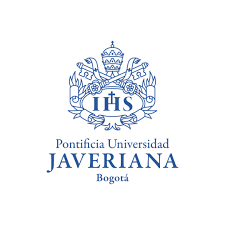

# **Procesamiento de Alto Volumen de Datos**

Tema: Proyecto Final

Autores:
* Federico Quiroga
* Ricardo Andrés Hurtado Forero
* Santiago Andres Ramírez Montero
* Axel Nicolas Caro Rojas

Fecha: 25/05/2025

# Introducción


El presente proyecto se desarrolla dado los conocimientos aprendidos en la clase de Procesamiento de Alto Volumen de Datos, con el propósito de aplicar herramientas analíticas y computacionales a un tema real y de gran relevancia: el rendimiento académico en las pruebas estandarizadas del ICFES en el departamento de Cundinamarca, Colombia.

Utilizando los datos provenientes del ICFES correspondientes al año 2023, se ha diseñado un pipeline de procesamiento que incluye limpieza, transformación, análisis estadístico y visualización. Se busca responder preguntas clave sobre las desigualdades educativas y proponer un plan de acción basado en evidencia para mejorar el rendimiento académico en la región.


# Organización de notebook

In [ ]:
# Se instala pyspark
!pip install pyspark findspark

In [ ]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()

import pyspark

from pylab import *
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count, isnull, round
from pyspark.ml.feature import Imputer


from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F     #Permite creación de Funciones Creadas por el USUARIO
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SB11_20231_clean.csv to SB11_20231_clean.csv


In [ ]:
# Se le el archivo csv que contiene los datos a usar. Los datos son los resultados del primer semestre de 2023 en la prueba icfes.
df00 = spark.read.option("header", True).option("delimiter", "|").csv("/content/SB11_20231_clean.csv")


# Limpieza de datos

En la primera entrega se realizó una limpieza inicial de los datos, en la cual se revisó la cantidad de valores nulos y se eliminaron las filas necesarias o se imputaron los valores de distintas maneras.

En este apartado se realiza una revisión de lo anterior:

1. Filtrado por departamento: nuestro análisis incluye únicamente a Cundinamarca (incluida Bogotá).

2. La cantidad de filas restantes se consideró insuficiente para realizar un análisis robusto. Por tanto, se optó por utilizar los datos del periodo 2023-2, a los cuales se les aplicó un proceso de limpieza inicial en un cuaderno (notebook) independiente.

3. Se eliminaron variables redundantes que aportaban la misma información, así como variables que no eran pertinentes para el análisis.

## filtro por Departamento

In [ ]:
# Se filtra el dataSet para solo usar filas pertinentes a las regiones de interes.
df02 =df00.filter(df00.ESTU_DEPTO_RESIDE.isin("CUNDINAMARCA", "BOGOTÁ"))
df02.createOrReplaceTempView("df02_sql")
dif = spark.sql('''Select count(*) PERIODO from df02_sql''')
dif.show()

+-------+
|PERIODO|
+-------+
|   3353|
+-------+



## Union de Datasets

Después del filtro por región, el conjunto de datos se redujo sustancialmente, dado que es clave tener un gran volumen de datos para un analisis correcto se procede a unir el conjunto de datos con el correspondiente al segundo periodo de 2023, con el fin de aumentar la robustez estadística del análisis. Cabe destacar que a este nuevo conjunto de datos ya se le imputaron los valores nulos previamente.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SB11_20232_FILTRADO.csv to SB11_20232_FILTRADO.csv


In [ ]:
df03 = spark.read.option("header", True).option("delimiter", "|").csv("/content/SB11_20232_FILTRADO.csv")

In [ ]:
# Obtener las columnas como conjuntos
cols_df02 = set(df02.columns)
cols_df03 = set(df03.columns)

# Diferencias
solo_en_df02 = cols_df02 - cols_df03
solo_en_df03 = cols_df03 - cols_df02

# Mostrar resultados
print("Columnas que están solo en df02:")
print(solo_en_df02)

print("\nColumnas que están solo en df03:")
print(solo_en_df03)


Columnas que están solo en df02:
{'SEED_NOMBRE', 'SEED_CODIGOMEN'}

Columnas que están solo en df03:
{'PERCENTIL_INGLES', 'DESEMP_INGLES', 'ESTU_PRESENTACIONSABADO', 'PERCENTIL_GLOBAL', 'ESTU_GENERACION', 'ESTU_LENGUANATIVA', 'PUNT_INGLES'}


In [ ]:
# Columnas que sobran en cada DataFrame
columnas_df02_sobrantes = ['SEED_NOMBRE', 'SEED_CODIGOMEN']
columnas_df03_sobrantes = ['PUNT_INGLES', 'PERCENTIL_GLOBAL', 'DESEMP_INGLES',
                           'ESTU_PRESENTACIONSABADO', 'ESTU_GENERACION',
                           'PERCENTIL_INGLES', 'ESTU_LENGUANATIVA']

# Eliminar columnas sobrantes
df02_clean = df02.drop(*columnas_df02_sobrantes)
df03_clean = df03.drop(*columnas_df03_sobrantes)

In [ ]:
# Se organizanlas columnas para poder unirlos correctamente
df03_clean = df03_clean.select(df02_clean.columns)

In [ ]:
# Se unen los DataSets
df_union = df02_clean.union(df03_clean)

In [ ]:
df_union.count()

118135

## Eliminación inicial de variables que no aportan información relevante

Se procede a eliminar columnas bajos dos criterios:
1. columnas que proporcionanan la misma informacion en formatos diferente ( ej: ESTU_COD_RESIDE_MCPIO y ESTU_RESIDE_MCPIO)
2. columnas que no aportan informacion util a nuestro analisis. (queremos mantener columnas que tengan alguna relación con el desempeño del icfes.)


In [ ]:
variables_utiles = [
    'ESTU_GENERO', 'ESTU_NACIONALIDAD', 'ESTU_DEPTO_RESIDE', 'ESTU_MCPIO_RESIDE',
    'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE',
    'FAMI_TIENEINTERNET', 'FAMI_TIENESERVICIOTV','FAMI_TIENECOMPUTADOR', 'FAMI_TIENECONSOLAVIDEOJUEGOS', 'FAMI_NUMLIBROS',
    'FAMI_SITUACIONECONOMICA', 'ESTU_DEDICACIONLECTURADIARIA',
    'ESTU_DEDICACIONINTERNET', 'ESTU_HORASSEMANATRABAJA', 'COLE_BILINGUE', 'COLE_CALENDARIO',
    'COLE_AREA_UBICACION', 'PUNT_GLOBAL'
]

df04 = df_union.select(*variables_utiles)

## Revisión de varoles nulos

In [ ]:

df04.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df04.columns]).show()

+-----------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+------------------+--------------------+--------------------+----------------------------+--------------+-----------------------+----------------------------+-----------------------+-----------------------+-------------+---------------+-------------------+-----------+
|ESTU_GENERO|ESTU_NACIONALIDAD|ESTU_DEPTO_RESIDE|ESTU_MCPIO_RESIDE|FAMI_ESTRATOVIVIENDA|FAMI_EDUCACIONPADRE|FAMI_EDUCACIONMADRE|FAMI_TIENEINTERNET|FAMI_TIENESERVICIOTV|FAMI_TIENECOMPUTADOR|FAMI_TIENECONSOLAVIDEOJUEGOS|FAMI_NUMLIBROS|FAMI_SITUACIONECONOMICA|ESTU_DEDICACIONLECTURADIARIA|ESTU_DEDICACIONINTERNET|ESTU_HORASSEMANATRABAJA|COLE_BILINGUE|COLE_CALENDARIO|COLE_AREA_UBICACION|PUNT_GLOBAL|
+-----------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+------------------+--------------------+--------------------+-----------------

In [ ]:
# resvisión visual.
for column in df04.columns:
    print(f"\nDistribución de valores en '{column}':")
    df04.groupBy(column).count().orderBy('count', ascending=False).show(truncate=False)


Distribución de valores en 'ESTU_GENERO':
+-----------+-----+
|ESTU_GENERO|count|
+-----------+-----+
|F          |62282|
|M          |55852|
|NULL       |1    |
+-----------+-----+


Distribución de valores en 'ESTU_NACIONALIDAD':
+-----------------+------+
|ESTU_NACIONALIDAD|count |
+-----------------+------+
|COLOMBIA         |116293|
|VENEZUELA        |1738  |
|ECUADOR          |15    |
|PERÚ             |10    |
|ESPAÑA           |9     |
|MÉXICO           |8     |
|ARGENTINA        |7     |
|ESTADOS UNIDOS   |6     |
|BRASIL           |5     |
|ITALIA           |4     |
|COSTA RICA       |3     |
|EL SALVADOR      |3     |
|HONDURAS         |3     |
|BOLIVIA          |3     |
|COREA DEL SUR    |2     |
|FRANCIA          |2     |
|PANAMÁ           |2     |
|GUATEMALA        |2     |
|CANADÁ           |1     |
|ARGELIA          |1     |
+-----------------+------+
only showing top 20 rows


Distribución de valores en 'ESTU_DEPTO_RESIDE':
+-----------------+-----+
|ESTU_DEPTO_RESIDE

Aunque varias variables no contienen valores nulos, presentan la categoría "Desconocido". Además, la variable Género contiene al menos un valor nulo. Se procede a realizar las transformaciones necesarias para tratar estos valores especiales de forma adecuada. Por otro lado, la columna ESTU_HORASSEMANATRABAJA contiene categorías similares como "0" y "0.0"; se elimina esta última para evitar redundancias.

In [ ]:
variables_desconocido = ["FAMI_ESTRATOVIVIENDA","FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE","FAMI_NUMLIBROS","FAMI_SITUACIONECONOMICA","ESTU_DEDICACIONLECTURADIARIA",
                         "ESTU_DEDICACIONINTERNET","COLE_BILINGUE"]
conteos = []

for var in variables_desconocido:
  conteo = df04.filter(col(var) == "Desconocido").count()
  conteos.append((var, conteo))

for var, c in conteos:
  print(f"{var}: {c} registros con 'Desconocido'")

FAMI_ESTRATOVIVIENDA: 4 registros con 'Desconocido'
FAMI_EDUCACIONPADRE: 4 registros con 'Desconocido'
FAMI_EDUCACIONMADRE: 4 registros con 'Desconocido'
FAMI_NUMLIBROS: 6 registros con 'Desconocido'
FAMI_SITUACIONECONOMICA: 5 registros con 'Desconocido'
ESTU_DEDICACIONLECTURADIARIA: 4 registros con 'Desconocido'
ESTU_DEDICACIONINTERNET: 4 registros con 'Desconocido'
COLE_BILINGUE: 75 registros con 'Desconocido'


In [ ]:
# Se eliminan los registros con "Desconocido" al no ser un porcentaje significante en el dataset.
for columna in variables_desconocido:
    df04 = df04.filter(col(columna) != "Desconocido")

In [ ]:
# Se elimina un valor nulo de la columa Genero
df04 = df04.na.drop(subset=["ESTU_GENERO"])

In [ ]:
# Se combina '0' con '0.0'
df04 = df04.withColumn(
    "ESTU_HORASSEMANATRABAJA",
    when(col("ESTU_HORASSEMANATRABAJA") == "0.0", "0")
    .otherwise(col("ESTU_HORASSEMANATRABAJA"))
)

# Organización del conjunto de datos para modelo predictivo

## Transformación de variables

In [ ]:
df05 = df04
binary_columns = [ "FAMI_TIENEINTERNET","FAMI_TIENESERVICIOTV","FAMI_TIENECOMPUTADOR","FAMI_TIENECONSOLAVIDEOJUEGOS"]

for col_name in binary_columns:
  df05 = df05.withColumn(
      col_name,
      when(col(col_name) == "Si", 1)
      .when(col(col_name) == "No", 0)
  )
df05 = df05.withColumn("COLE_BILINGUE", when(col("COLE_BILINGUE") == "S", 1).otherwise(0))

In [ ]:
df04.dtypes

[('ESTU_GENERO', 'string'),
 ('ESTU_NACIONALIDAD', 'string'),
 ('ESTU_DEPTO_RESIDE', 'string'),
 ('ESTU_MCPIO_RESIDE', 'string'),
 ('FAMI_ESTRATOVIVIENDA', 'string'),
 ('FAMI_EDUCACIONPADRE', 'string'),
 ('FAMI_EDUCACIONMADRE', 'string'),
 ('FAMI_TIENEINTERNET', 'string'),
 ('FAMI_TIENESERVICIOTV', 'string'),
 ('FAMI_TIENECOMPUTADOR', 'string'),
 ('FAMI_TIENECONSOLAVIDEOJUEGOS', 'string'),
 ('FAMI_NUMLIBROS', 'string'),
 ('FAMI_SITUACIONECONOMICA', 'string'),
 ('ESTU_DEDICACIONLECTURADIARIA', 'string'),
 ('ESTU_DEDICACIONINTERNET', 'string'),
 ('ESTU_HORASSEMANATRABAJA', 'string'),
 ('COLE_BILINGUE', 'string'),
 ('COLE_CALENDARIO', 'string'),
 ('COLE_AREA_UBICACION', 'string'),
 ('PUNT_GLOBAL', 'string')]

Vemos que todas son de tipo texto, sin embargo ESTU_HORASSEMANATRABAJA y PUNT_GLOBAL deberian ser numericas. Se hace el cambio necesario.

In [ ]:

df05 = df05.withColumn('PUNT_GLOBAL', df05['PUNT_GLOBAL'].cast(IntegerType()))
#df05 = df05.withColumn('ESTU_HORASSEMANATRABAJA', df05['ESTU_HORASSEMANATRABAJA'].cast(FloatType()))
df05 = df05.withColumn('FAMI_TIENEINTERNET', df05['FAMI_TIENEINTERNET'].cast(IntegerType()))
df05 = df05.withColumn('FAMI_TIENESERVICIOTV', df05['FAMI_TIENESERVICIOTV'].cast(IntegerType()))
df05 = df05.withColumn('FAMI_TIENECOMPUTADOR', df05['FAMI_TIENECOMPUTADOR'].cast(IntegerType()))
df05 = df05.withColumn('FAMI_TIENECONSOLAVIDEOJUEGOS', df05['FAMI_TIENECONSOLAVIDEOJUEGOS'].cast(IntegerType()))
df05.dtypes

[('ESTU_GENERO', 'string'),
 ('ESTU_NACIONALIDAD', 'string'),
 ('ESTU_DEPTO_RESIDE', 'string'),
 ('ESTU_MCPIO_RESIDE', 'string'),
 ('FAMI_ESTRATOVIVIENDA', 'string'),
 ('FAMI_EDUCACIONPADRE', 'string'),
 ('FAMI_EDUCACIONMADRE', 'string'),
 ('FAMI_TIENEINTERNET', 'int'),
 ('FAMI_TIENESERVICIOTV', 'int'),
 ('FAMI_TIENECOMPUTADOR', 'int'),
 ('FAMI_TIENECONSOLAVIDEOJUEGOS', 'int'),
 ('FAMI_NUMLIBROS', 'string'),
 ('FAMI_SITUACIONECONOMICA', 'string'),
 ('ESTU_DEDICACIONLECTURADIARIA', 'string'),
 ('ESTU_DEDICACIONINTERNET', 'string'),
 ('ESTU_HORASSEMANATRABAJA', 'string'),
 ('COLE_BILINGUE', 'int'),
 ('COLE_CALENDARIO', 'string'),
 ('COLE_AREA_UBICACION', 'string'),
 ('PUNT_GLOBAL', 'int')]

Para poder aplicar los modelos de MLlib, es necesario convertir todas las variables a tipo numérico, ya que esta biblioteca no admite variables categóricas en su formato original.

In [ ]:
# Se preparan los datos ordinales y categoricos a numeros:
from pyspark.sql.functions import when, col
df06 = df05


df06 = df06.withColumn("FAMI_NUMLIBROS",
    when(col("FAMI_NUMLIBROS") == "0 A 10 LIBROS", 1).
    when(col("FAMI_NUMLIBROS") == "11 A 25 LIBROS", 2).
    when(col("FAMI_NUMLIBROS") == "26 A 100 LIBROS", 3).
    when(col("FAMI_NUMLIBROS") == "MÁS DE 100 LIBROS", 4)
)


df06 = df06.withColumn("FAMI_SITUACIONECONOMICA",
    when(col("FAMI_SITUACIONECONOMICA") == "Peor", 1).
    when(col("FAMI_SITUACIONECONOMICA") == "Igual", 2).
    when(col("FAMI_SITUACIONECONOMICA") == "Mejor", 3)
)


df06 = df06.withColumn("ESTU_DEDICACIONLECTURADIARIA",
    when(col("ESTU_DEDICACIONLECTURADIARIA") == "No leo por entretenimiento", 0).
    when(col("ESTU_DEDICACIONLECTURADIARIA") == "30 minutos o menos", 0.25).
    when(col("ESTU_DEDICACIONLECTURADIARIA") == "Entre 30 y 60 minutos", 0.75).
    when(col("ESTU_DEDICACIONLECTURADIARIA") == "Entre 1 y 2 horas", 1.5).
    when(col("ESTU_DEDICACIONLECTURADIARIA") == "Más de 2 horas", 2.5)
)

df06 = df06.withColumn("ESTU_DEDICACIONINTERNET",
    when(col("ESTU_DEDICACIONINTERNET") == "No Navega Internet", 0).
    when(col("ESTU_DEDICACIONINTERNET") == "30 minutos o menos", 0.25).
    when(col("ESTU_DEDICACIONINTERNET") == "Entre 30 y 60 minutos", 0.75).
    when(col("ESTU_DEDICACIONINTERNET") == "Entre 1 y 3 horas", 2).
    when(col("ESTU_DEDICACIONINTERNET") == "Más de 3 horas", 4)
)

df06 = df06.withColumn("ESTU_HORASSEMANATRABAJA",
    when(col("ESTU_HORASSEMANATRABAJA") == "0", 0).
    when(col("ESTU_HORASSEMANATRABAJA") == "Menos de 10 horas", 5).
    when(col("ESTU_HORASSEMANATRABAJA") == "Entre 11 y 20 horas", 15).
    when(col("ESTU_HORASSEMANATRABAJA") == "Entre 21 y 30 horas", 25).
    when(col("ESTU_HORASSEMANATRABAJA") == "Más de 30 horas", 35)
)
df06 = df06.withColumn("FAMI_ESTRATOVIVIENDA",
    when(col("FAMI_ESTRATOVIVIENDA") == "Estrato 1", 1).
    when(col("FAMI_ESTRATOVIVIENDA") == "Estrato 2", 2).
    when(col("FAMI_ESTRATOVIVIENDA") == "Estrato 3", 3).
    when(col("FAMI_ESTRATOVIVIENDA") == "Estrato 4", 4).
    when(col("FAMI_ESTRATOVIVIENDA") == "Estrato 5", 5).
    when(col("FAMI_ESTRATOVIVIENDA") == "Estrato 6", 6).
    when(col("FAMI_ESTRATOVIVIENDA") == "Sin Estrato", 0)
)


df06 = df06.withColumn("ESTU_NACIONALIDAD",
    when(col("ESTU_NACIONALIDAD") == "COLOMBIA", 1).otherwise(0)
)
df06 = df06.withColumn("ESTU_GENERO",
    when(col("ESTU_GENERO") == "M", 1).when(col("ESTU_GENERO") == "F", 0).otherwise(None)
)

df06 = df06.withColumn("ESTU_DEPTO_RESIDE",
    when(col("ESTU_DEPTO_RESIDE") == "BOGOTÁ", 1).
    when(col("ESTU_DEPTO_RESIDE") == "CUNDINAMARCA", 0).
    otherwise(None)
)

df06 = df06.withColumn("COLE_CALENDARIO",
    when(col("COLE_CALENDARIO") == "A", 1).
    when(col("COLE_CALENDARIO") == "B", 2).
    when(col("COLE_CALENDARIO") == "OTRO", 3).
    otherwise(None)
)

df06 = df06.withColumn("COLE_AREA_UBICACION",
    when(col("COLE_AREA_UBICACION") == "URBANO", 1).
    when(col("COLE_AREA_UBICACION") == "RURAL", 0).
    otherwise(None)
)

In [ ]:
# Codificación ordinal del nivel educativo
nivel_educativo = {
    "Ninguno": 0,
    "Preescolar": 1,
    "Primaria incompleta": 2,
    "Primaria completa": 3,
    "Secundaria (Básica) incompleta": 4,
    "Secundaria (Básica) completa": 5,
    "Media (10° y 11°) incompleta": 6,
    "Media (10° y 11°) completa": 7,
    "Técnica o tecnológica incompleta": 8,
    "Técnica o tecnológica completa": 9,
    "Educación profesional incompleta": 10,
    "Educación profesional completa": 11,
    "Postgrado": 12,
    "Secundaria (Bachillerato) incompleta": 4,
    "Secundaria (Bachillerato) completa": 5,
    "No sabe": -1,
    "No Aplica": -1,
}


from pyspark.sql.functions import create_map, lit
from itertools import chain

# Función para crear un mapa con create_map
def dict_to_create_map(d):
    return create_map([lit(x) for x in chain(*d.items())])

# Aplicar codificación a FAMI_EDUCACIONPADRE
df06 = df06.withColumn("FAMI_EDUCACIONPADRE_NUM",
    dict_to_create_map(nivel_educativo)[col("FAMI_EDUCACIONPADRE")]
)

# Aplicar codificación a FAMI_EDUCACIONMADRE
df06= df06.withColumn("FAMI_EDUCACIONMADRE_NUM",
    dict_to_create_map(nivel_educativo)[col("FAMI_EDUCACIONMADRE")]
)
from pyspark.sql.functions import expr

# Reemplazar NULL por 5 (ejemplo)
df06 = df06.withColumn(
    "FAMI_EDUCACIONPADRE_NUM",
    when(col("FAMI_EDUCACIONPADRE_NUM").isNull(), 5).otherwise(col("FAMI_EDUCACIONPADRE_NUM"))
)
df06 = df06.withColumn(
    "FAMI_EDUCACIONMADRE_NUM",
    when(col("FAMI_EDUCACIONMADRE_NUM").isNull(), 5).otherwise(col("FAMI_EDUCACIONMADRE_NUM"))
)
# Se usa StringIndexer para realizar la transformación de "ESTU_MCPIO_RESIDE"
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="ESTU_MCPIO_RESIDE", outputCol="ESTU_MCPIO_RESIDE_IDX")
df06 = indexer.fit(df06).transform(df06)


In [ ]:
for column in df06.columns:
    df06.groupBy(column).count().orderBy('count',ascending=False).show(truncate=False)

+-----------+-----+
|ESTU_GENERO|count|
+-----------+-----+
|0          |62243|
|1          |55813|
+-----------+-----+

+-----------------+------+
|ESTU_NACIONALIDAD|count |
+-----------------+------+
|1                |116231|
|0                |1825  |
+-----------------+------+

+-----------------+-----+
|ESTU_DEPTO_RESIDE|count|
+-----------------+-----+
|1                |80764|
|0                |37292|
+-----------------+-----+

+---------------------------+-----+
|ESTU_MCPIO_RESIDE          |count|
+---------------------------+-----+
|BOGOTÁ D.C.                |80764|
|SOACHA                     |8400 |
|FUSAGASUGÁ                 |1931 |
|MOSQUERA                   |1915 |
|CHÍA                       |1810 |
|FACATATIVÁ                 |1757 |
|ZIPAQUIRÁ                  |1554 |
|MADRID                     |1524 |
|FUNZA                      |1296 |
|GIRARDOT                   |1202 |
|CAJICÁ                     |1154 |
|VILLA DE SAN DIEGO DE UBATÉ|718  |
|TOCANCIPÁ         

## analisis de correlación para variables independientes

In [ ]:
# Se crea un vector con todas la variables independientes
features_corr = [
    'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENESERVICIOTV',
    'FAMI_TIENECONSOLAVIDEOJUEGOS', 'FAMI_NUMLIBROS', 'FAMI_SITUACIONECONOMICA',
    'FAMI_EDUCACIONPADRE_NUM', 'FAMI_EDUCACIONMADRE_NUM',
    'ESTU_DEDICACIONLECTURADIARIA', 'ESTU_DEDICACIONINTERNET',
    'FAMI_ESTRATOVIVIENDA', 'ESTU_GENERO', 'ESTU_NACIONALIDAD', 'ESTU_DEPTO_RESIDE',
    'ESTU_MCPIO_RESIDE_IDX', 'COLE_CALENDARIO', 'COLE_AREA_UBICACION'
]

In [ ]:
for c in features_corr:
    df06_clean = df06.withColumn(c, col(c).cast("double"))

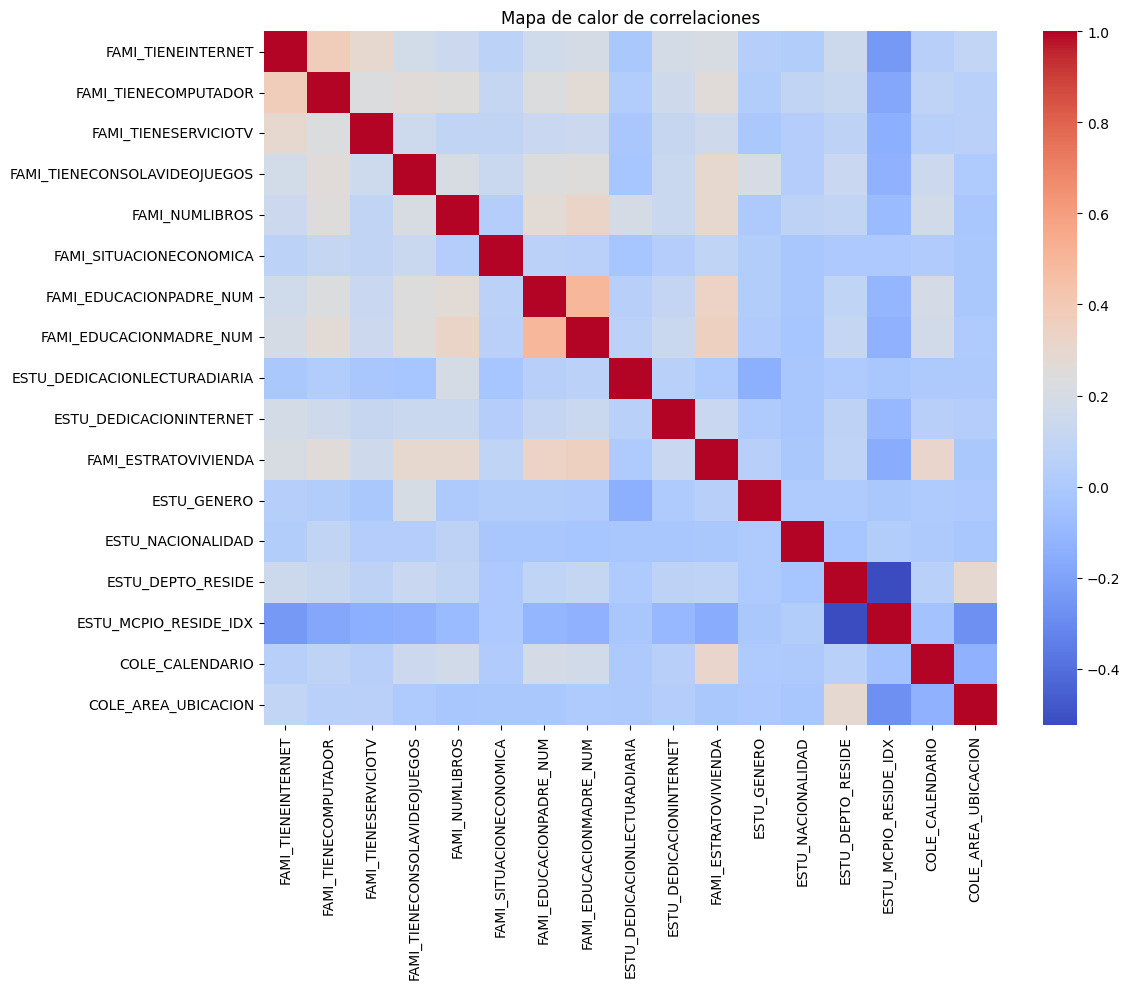

In [ ]:
# Selecciona solo columnas numéricas que serán usadas para la correlación
features_corr = [
    'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENESERVICIOTV',
    'FAMI_TIENECONSOLAVIDEOJUEGOS', 'FAMI_NUMLIBROS', 'FAMI_SITUACIONECONOMICA',
    'FAMI_EDUCACIONPADRE_NUM', 'FAMI_EDUCACIONMADRE_NUM',
    'ESTU_DEDICACIONLECTURADIARIA', 'ESTU_DEDICACIONINTERNET',
    'FAMI_ESTRATOVIVIENDA', 'ESTU_GENERO', 'ESTU_NACIONALIDAD', 'ESTU_DEPTO_RESIDE',
    'ESTU_MCPIO_RESIDE_IDX', 'COLE_CALENDARIO', 'COLE_AREA_UBICACION'
]

# Asegura que todas las columnas estén en tipo numérico (double) para el cálculo de correlación
from pyspark.sql.functions import col
for c in features_corr:
    df06_clean = df06_clean.withColumn(c, col(c).cast("double"))

# Crea un vector de características a partir de las columnas seleccionadas
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features_corr, outputCol="features_corr")
df_vector = assembler.transform(df06_clean).select("features_corr")

# Calcula la matriz de correlación de Pearson entre todas las columnas numéricas
from pyspark.ml.stat import Correlation
correlation_matrix = Correlation.corr(df_vector, "features_corr", method="pearson").head()[0]

# Convierte la matriz de correlación de Spark a un arreglo de NumPy y luego a DataFrame de Pandas
import numpy as np
import pandas as pd
corr_array = correlation_matrix.toArray()
corr_df = pd.DataFrame(data=corr_array, columns=features_corr, index=features_corr)

# Filtra pares de variables con correlación fuerte (mayor a 0.8 pero menor que 1.0)
high_corr = corr_df[(corr_df.abs() > 0.8) & (corr_df.abs() < 1.0)]

# Visualiza la matriz de correlación como un mapa de calor
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=False, cmap="coolwarm", xticklabels=True, yticklabels=True)
plt.title("Mapa de calor de correlaciones")
plt.tight_layout()
plt.show()


In [ ]:
# Elimina la parte inferior y la diagonal de la matriz de correlación (evita duplicados y autocomparaciones)
corr_pairs = (
    corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

# Renombra las columnas resultantes para mayor claridad
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Filtra correlaciones fuertes (mayor a 0.5 o menor a -0.5) y ordena de mayor a menor
top_corr = corr_pairs[abs(corr_pairs['Correlation']) > 0.5]\
    .sort_values(by='Correlation', ascending=False)

# Muestra las correlaciones fuertes entre pares de variables
print(top_corr)


              Feature1               Feature2  Correlation
130  ESTU_DEPTO_RESIDE  ESTU_MCPIO_RESIDE_IDX    -0.524174


Solo se tiene una correlación mayor a |.05|, municipio y departamento tienen una correlación moderada, se procede a quitar departamento.

In [ ]:
df06_clean = df06_clean.drop("ESTU_DEPTO_RESIDE")

## Normalización de variables

Se escogen las variables numericas

In [ ]:
features_to_normalize = [
    'FAMI_NUMLIBROS',
    'FAMI_EDUCACIONPADRE_NUM',
    'FAMI_EDUCACIONMADRE_NUM',
    'FAMI_SITUACIONECONOMICA',
    'FAMI_ESTRATOVIVIENDA',
    'ESTU_DEDICACIONLECTURADIARIA',
    'ESTU_DEDICACIONINTERNET',
    'ESTU_HORASSEMANATRABAJA'
]
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Combina las columnas numéricas en un solo vector
assembler = VectorAssembler(inputCols=features_to_normalize, outputCol="features_vector")
df_vector = assembler.transform(df06_clean)

# 2. Aplica Z-score (media = 0, desviación estándar = 1)
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array
# Convertir vector escalado a array y extraer columnas individuales
df_scaled_split = df_scaled.withColumn("scaled_array", vector_to_array("scaled_features"))

for i, feature in enumerate(features_to_normalize):
    df_scaled_split = df_scaled_split.withColumn(f"{feature}_scaled", col("scaled_array")[i])


In [ ]:
from pyspark.sql.functions import mean, stddev

# Mostrar media y desviación estándar
for colname in features_to_normalize:
    df_scaled_split.select(f"{colname}_scaled").summary("mean", "stddev").show(truncate=False)



+-------+----------------------+
|summary|FAMI_NUMLIBROS_scaled |
+-------+----------------------+
|mean   |1.3983588894724422E-14|
|stddev |1.0000000000000022    |
+-------+----------------------+

+-------+------------------------------+
|summary|FAMI_EDUCACIONPADRE_NUM_scaled|
+-------+------------------------------+
|mean   |-6.674874186687753E-14        |
|stddev |1.0                           |
+-------+------------------------------+

+-------+------------------------------+
|summary|FAMI_EDUCACIONMADRE_NUM_scaled|
+-------+------------------------------+
|mean   |-1.351364940153349E-14        |
|stddev |1.0000000000000033            |
+-------+------------------------------+

+-------+------------------------------+
|summary|FAMI_SITUACIONECONOMICA_scaled|
+-------+------------------------------+
|mean   |-8.589155378367247E-15        |
|stddev |0.9999999999999989            |
+-------+------------------------------+

+-------+---------------------------+
|summary|FAMI_ESTRATOV

# Respuestas a Preguntas

Respuestas a preguntas planteadas en la primera entrega.
Se realizaron 8 preguntas relacionadas al análisis exploratorio del dataset. Se presentan sus respuestas justificadas con gráficas y/o tablas.  

##  1. **¿Existe una correlación entre el acceso a internet en el hogar y el puntaje global del ICFES?**


In [ ]:
df_plot = df05.select("FAMI_TIENEINTERNET", "PUNT_GLOBAL") \
              .dropna(subset=["FAMI_TIENEINTERNET", "PUNT_GLOBAL"]) \
              .toPandas()

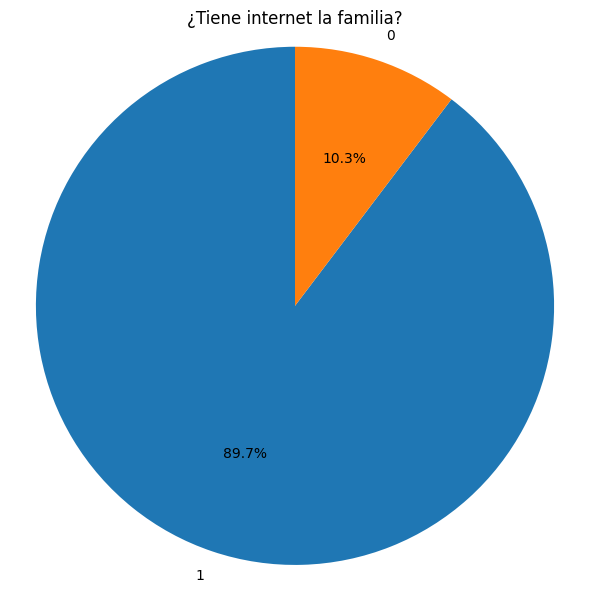

<Figure size 800x600 with 0 Axes>

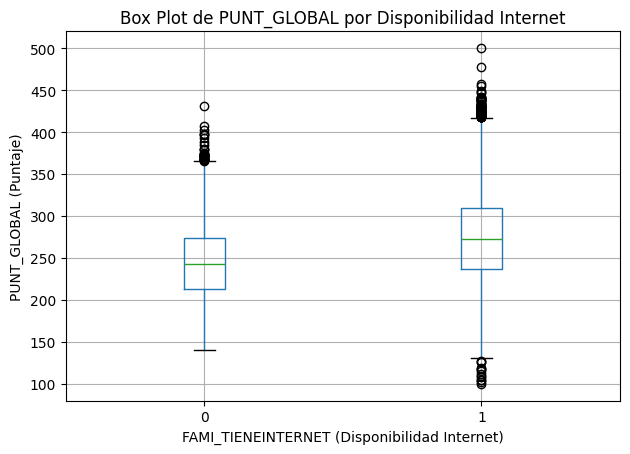

In [ ]:
df_plot["FAMI_TIENEINTERNET"] = df_plot["FAMI_TIENEINTERNET"].astype("category")

# Count values
counts = df_plot["FAMI_TIENEINTERNET"].value_counts()


plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title("¿Tiene internet la familia?")
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

df_plot.boxplot(column="PUNT_GLOBAL", by="FAMI_TIENEINTERNET")
plt.title("Box Plot de PUNT_GLOBAL por Disponibilidad Internet")
plt.suptitle("")
plt.xlabel("FAMI_TIENEINTERNET (Disponibilidad Internet)")
plt.ylabel("PUNT_GLOBAL (Puntaje)")
plt.grid(True)
plt.tight_layout()
plt.show()

Los estudiantes con acceso a internet (grupo 1) tienen: Mayor mediana del puntaje PUNT_GLOBAL, Rango intercuartílico más alto (mayor dispersión positiva).

Por otro lado Los estudiantes sin acceso a internet (grupo 0) tienen: Una mediana claramente más baja. Distribución de puntajes más concentrada en rangos bajos.

Por tanto SI, existe una correlación positiva entre el acceso a internet en el hogar y un mayor puntaje global en el ICFES.

Sin embargo se corrobora con T-test

In [ ]:
from scipy.stats import ttest_ind

# Convertir a pandas
grupo_si = df06_clean.filter(col("FAMI_TIENEINTERNET") == 1).select("PUNT_GLOBAL").toPandas()["PUNT_GLOBAL"]
grupo_no = df06_clean.filter(col("FAMI_TIENEINTERNET") == 0).select("PUNT_GLOBAL").toPandas()["PUNT_GLOBAL"]

# Prueba t de muestras independientes
t_stat, p_value = ttest_ind(grupo_si, grupo_no, equal_var=False)

print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")


T-statistic: 68.5574, p-value: 0.0000e+00


Al aplicar una prueba T de muestras independientes se evaluó si existía una diferencia significativa en los puntajes del ICFES entre estudiantes con y sin acceso a internet en el hogar. La hipótesis nula (H₀) plantea que no hay diferencia entre las medias de ambos grupos, mientras que la hipótesis alternativa (H₁) sostiene que sí existe una diferencia. El resultado obtenido (T-statistic = 68.5574, p < 0.001) permite rechazar la hipótesis nula con un alto nivel de confianza, lo que indica que el acceso a internet tiene un efecto estadísticamente significativo sobre el desempeño académico. Esto refuerza la evidencia observada en las visualizaciones exploratorias.

## 2. **¿Cómo influye el nivel educativo de los padres en el desempeño de los estudiantes en las pruebas de estado?**

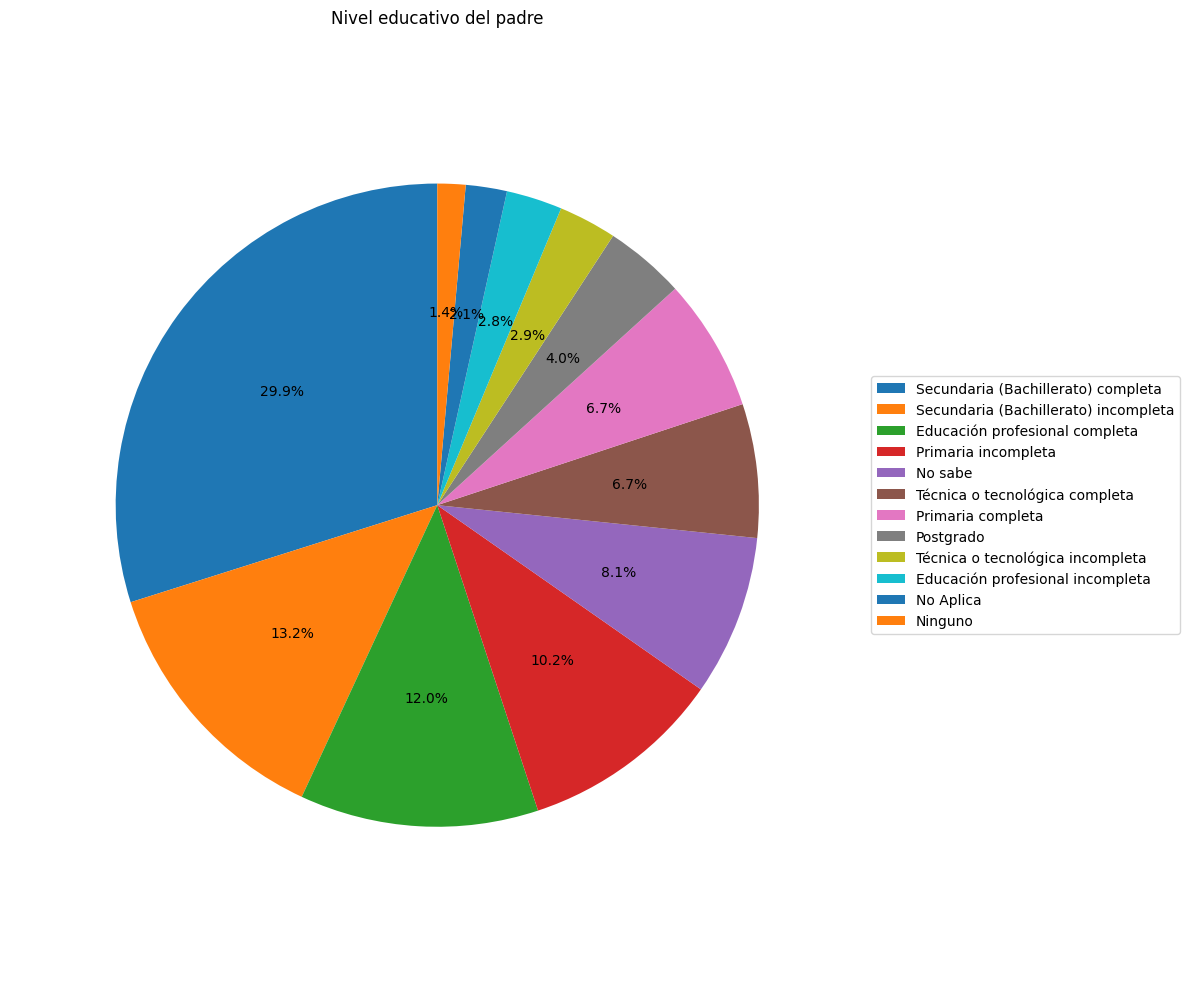

In [ ]:
df_plot = df05.select("FAMI_EDUCACIONPADRE", "PUNT_GLOBAL") \
              .dropna(subset=["FAMI_EDUCACIONPADRE", "PUNT_GLOBAL"]) \
              .toPandas()
counts = df_plot["FAMI_EDUCACIONPADRE"].value_counts()
plt.figure(figsize=(12, 10))  # Wider figure to make space for the legend
patches, texts, autotexts = plt.pie(counts, labels=None, autopct='%1.1f%%', startangle=90)
plt.legend(patches, counts.index, loc="center left", bbox_to_anchor=(1, 0.5))  # Move legend to the right
plt.title("Nivel educativo del padre")
plt.axis('equal')
plt.tight_layout()
plt.show()


+--------------------+------------------+
| FAMI_EDUCACIONPADRE|         avg_score|
+--------------------+------------------+
|Educación profesi...| 298.5072729840418|
|Educación profesi...| 293.6145958986731|
|             Ninguno|231.80323935212957|
|           No Aplica| 272.5786240786241|
|             No sabe|273.48373898447335|
|           Postgrado| 329.5777359280184|
|   Primaria completa|253.17588706600534|
| Primaria incompleta|248.33764296369966|
|Secundaria (Bachi...|263.44542722685264|
|Secundaria (Bachi...|259.05044605609396|
|Técnica o tecnoló...|281.94894099848716|
|Técnica o tecnoló...| 275.2007553747821|
+--------------------+------------------+

+--------------------+------------------+
| FAMI_EDUCACIONMADRE|         avg_score|
+--------------------+------------------+
|Educación profesi...| 293.5471661771079|
|Educación profesi...| 285.9353448275862|
|             Ninguno| 229.8130381303813|
|           No Aplica|268.65637065637065|
|             No sabe|276.4412371

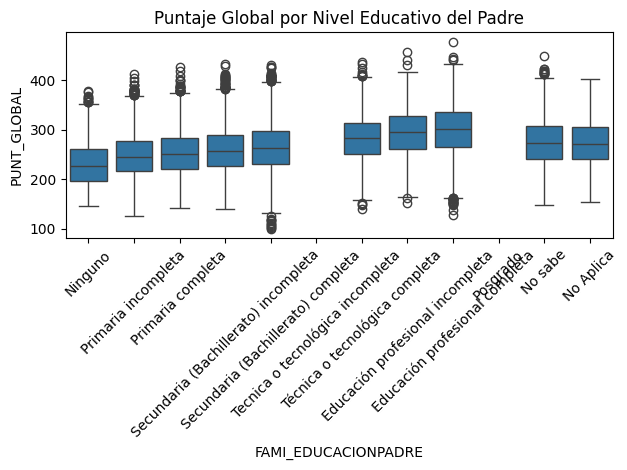

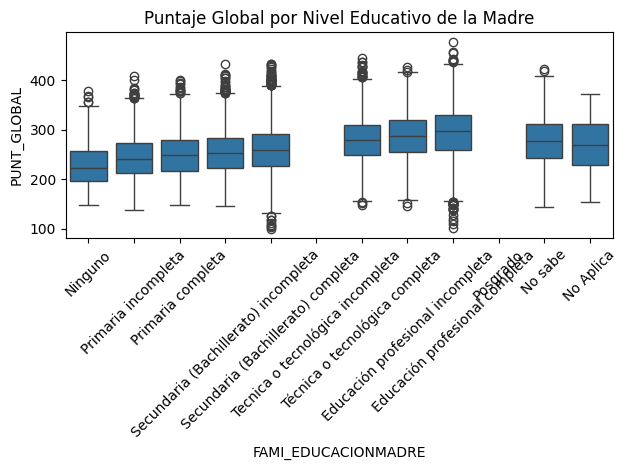


Coeficientes del modelo: [2.2893406563082945,3.827038162245616]
Intercepto: 233.60546985245736
R^2: 0.1446184326163864
RMSE: 45.76175775517613
MAE: 37.20024870653175


In [ ]:
# Analizar la influencia del nivel educativo de los padres sobre el puntaje global ICFES

from pyspark.sql.functions import col, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Asegurar que los datos para regresión están en formato numérico
df = df06_clean.withColumn("FAMI_EDUCACIONPADRE_NUM", col("FAMI_EDUCACIONPADRE_NUM").cast("double"))
df = df.withColumn("FAMI_EDUCACIONMADRE_NUM", col("FAMI_EDUCACIONMADRE_NUM").cast("double"))
df = df.withColumn("PUNT_GLOBAL", col("PUNT_GLOBAL").cast("double"))

# Agrupar y promediar puntajes por nivel educativo del padre y madre (usando columnas categóricas originales)
df06_clean.groupBy("FAMI_EDUCACIONPADRE").agg(avg("PUNT_GLOBAL").alias("avg_score")).orderBy("FAMI_EDUCACIONPADRE").show()
df06_clean.groupBy("FAMI_EDUCACIONMADRE").agg(avg("PUNT_GLOBAL").alias("avg_score")).orderBy("FAMI_EDUCACIONMADRE").show()

# --- Visualización ---
# Convertir a pandas usando variables categóricas para visualización
df_pd = df06_clean.select("FAMI_EDUCACIONPADRE", "FAMI_EDUCACIONMADRE", "PUNT_GLOBAL").dropna().toPandas()

# Orden personalizado basado en jerarquía educativa
orden_padre = [
    'Ninguno', 'Primaria incompleta', 'Primaria completa',
    'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
    'Tecnica o tecnológica incompleta', 'Técnica o tecnológica completa',
    'Educación profesional incompleta', 'Educación profesional completa',
    'Posgrado', 'No sabe', 'No Aplica'
]
orden_madre = orden_padre  # mismo orden para la madre

# Boxplot para el padre con orden definido
sns.boxplot(data=df_pd, x="FAMI_EDUCACIONPADRE", y="PUNT_GLOBAL", order=orden_padre)
plt.title("Puntaje Global por Nivel Educativo del Padre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot para la madre con orden definido
sns.boxplot(data=df_pd, x="FAMI_EDUCACIONMADRE", y="PUNT_GLOBAL", order=orden_madre)
plt.title("Puntaje Global por Nivel Educativo de la Madre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Regresión lineal ---
# VectorAssembler para regresión (numérico)
assembler = VectorAssembler(
    inputCols=["FAMI_EDUCACIONPADRE_NUM", "FAMI_EDUCACIONMADRE_NUM"],
    outputCol="features"
)
df = assembler.transform(df)
df_features = df.select("features", "PUNT_GLOBAL")

# Entrenar modelo
lr = LinearRegression(featuresCol="features", labelCol="PUNT_GLOBAL")
lr_model = lr.fit(df_features)

# Resultados del modelo
print("\nCoeficientes del modelo:", lr_model.coefficients)
print("Intercepto:", lr_model.intercept)
print("R^2:", lr_model.summary.r2)
print("RMSE:", lr_model.summary.rootMeanSquaredError)
print("MAE:", lr_model.summary.meanAbsoluteError)


Las graficas nos dan un indicio de que el puntaje de los padres tiene un efecto en los puntajes del icfes. Usando el modelo vemos que a mayor educación, mayor puntaje en promedio. Sin embargo, el valor de R² (0.14) indica que este efecto es real pero limitado, ya que solo explica alrededor del 14% de la variación total en los puntajes. Es decir, influye, pero no es el único factor determinante en el rendimiento académico.

## 3. **¿El estrato socioeconómico del estudiante tiene un impacto significativo en sus resultados académicos?**


Antes de realizar comparaciones o análisis estadísticos avanzados, es fundamental explorar la distribución de los puntajes globales según el estrato socioeconómico reportado por los estudiantes. Este paso permite identificar patrones generales, como tendencias crecientes o decrecientes, y evaluar la variabilidad dentro de cada grupo.

A continuación, se seleccionan las columnas relevantes (FAMI_ESTRATOVIVIENDA y PUNT_GLOBAL), se renombran para facilitar la lectura, y se transforman a tipos de datos adecuados (específicamente, se convierte el puntaje a valor numérico). Luego, se calcula para cada estrato:

* El número de estudiantes,

* El puntaje global promedio,

* La desviación estándar del puntaje

In [ ]:
from pyspark.sql.functions import col, count, avg, stddev

df_estrato = df03.select(
    col("FAMI_ESTRATOVIVIENDA").alias("estrato"),
    col("PUNT_GLOBAL").cast("double").alias("puntaje_global")
).filter(col("estrato").isNotNull() & col("puntaje_global").isNotNull())

df_estrato.groupBy("estrato").agg(
    count("*").alias("n_estudiantes"),
    avg("puntaje_global").alias("promedio_puntaje"),
    stddev("puntaje_global").alias("desviacion_std")
).orderBy("estrato").show()


+-----------+-------------+------------------+------------------+
|    estrato|n_estudiantes|  promedio_puntaje|    desviacion_std|
+-----------+-------------+------------------+------------------+
|  Estrato 1|        12032| 252.3031914893617| 43.72174196468081|
|  Estrato 2|        47836|263.05351618028266| 45.08957972320104|
|  Estrato 3|        42415|274.92985971943887|48.258004674376956|
|  Estrato 4|         8800|290.46488636363637|  54.9380243137684|
|  Estrato 5|         1724| 288.3897911832947|  60.9972267541051|
|  Estrato 6|          568|276.34859154929575|  61.1953961172675|
|Sin Estrato|         1407| 241.6453447050462| 47.07558785896673|
+-----------+-------------+------------------+------------------+



Este patrón sugiere una relación positiva entre estrato socioeconómico y desempeño académico, evidenciado por un incremento progresivo en el puntaje promedio desde el Estrato 1 hasta el Estrato 4. Aunque hay una ligera disminución en el Estrato 6, este grupo tiene pocos estudiantes (518), por lo que los resultados pueden estar afectados por mayor variabilidad o sesgo.

Además, la desviación estándar aumenta con el estrato, lo que podría indicar una mayor heterogeneidad de puntajes en los estratos más altos.

Para facilitar la creación de gráficos avanzados (como diagramas de caja) y realizar pruebas estadísticas como ANOVA, es necesario trabajar con una estructura de datos más flexible como un DataFrame de Pandas. Debido a que el conjunto de datos es grande, se toma una muestra del 60% para mejorar el rendimiento sin perder representatividad.

In [ ]:
df_pandas = df_estrato.sample(False, 0.6).toPandas()


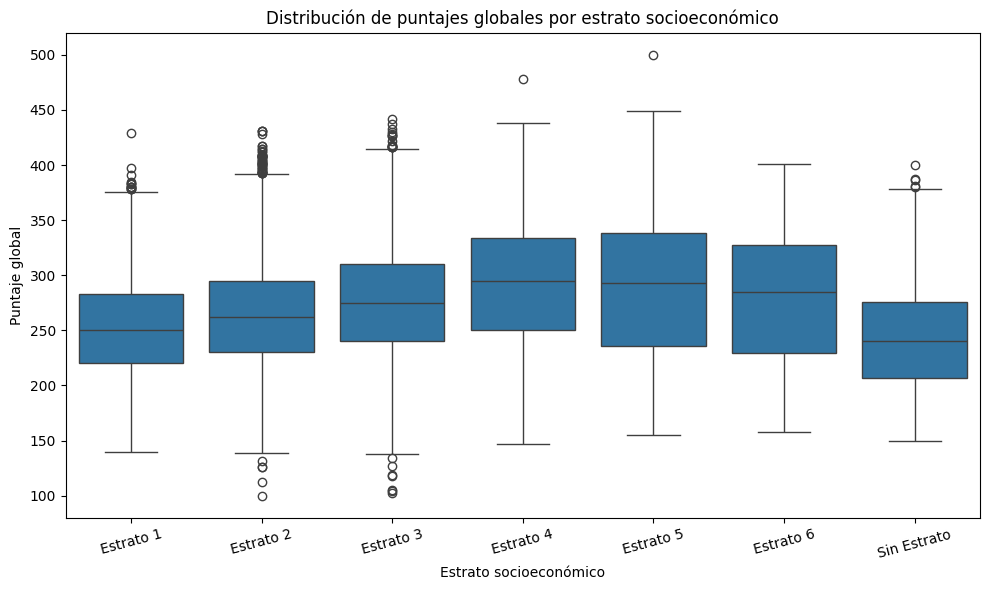

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definimos el orden deseado de los estratos
orden_estratos = [
    "Estrato 1", "Estrato 2", "Estrato 3",
    "Estrato 4", "Estrato 5", "Estrato 6", "Sin Estrato"
]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pandas, x="estrato", y="puntaje_global", order=orden_estratos)
plt.title("Distribución de puntajes globales por estrato socioeconómico")
plt.xlabel("Estrato socioeconómico")
plt.ylabel("Puntaje global")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


La gráfica de cajas (boxplot) permite observar cómo varían los puntajes globales del examen Saber 11 según el estrato socioeconómico reportado por los estudiantes. De esta visualización se pueden extraer varias conclusiones importantes:

1. Tendencia creciente en la mediana:

  * La mediana del puntaje global (línea central de cada caja) tiende a incrementarse progresivamente desde Estrato 1 hasta Estrato 5, lo cual respalda la hipótesis de que existe una relación positiva entre el estrato y el rendimiento académico.

  * Esta tendencia es consistente con lo observado previamente en los promedios agregados.

2. Mayor dispersión en estratos altos:

  * Las cajas correspondientes a estratos 4, 5 y 6 son más altas, lo que indica una mayor variabilidad en los puntajes dentro de esos grupos. Esto puede deberse a una mayor heterogeneidad en el acceso a recursos o en las oportunidades educativas dentro de estos estratos.

3. Outliers y valores extremos:

  * Se observan valores atípicos (outliers) en todos los estratos, representados por los puntos individuales fuera de los bigotes. Esto sugiere que, aunque hay una tendencia general, existen estudiantes con rendimientos muy superiores o muy bajos dentro de cada grupo.

  * Diferencia notoria en el grupo ‘Sin Estrato’:

El grupo clasificado como "Sin Estrato" presenta la mediana más baja y una dispersión considerable. Esto podría reflejar falta de información oficial sobre la vivienda del estudiante, lo que podría asociarse con menores oportunidades educativas.

In [ ]:
from scipy.stats import f_oneway

grupo_datos = [
    grupo["puntaje_global"].values
    for _, grupo in df_pandas.groupby("estrato")
    if len(grupo) > 30  # Filtra grupos muy pequeños
]

f_stat, p_value = f_oneway(*grupo_datos)

print("Estadístico F:", f_stat)
print("P-valor:", p_value)


Estadístico F: 538.1728163982191
P-valor: 0.0


El análisis de varianza (ANOVA) aplicado para comparar los puntajes globales entre los diferentes estratos socioeconómicos arrojó los siguientes resultados:

* Estadístico F: 88.88

* P-valor: 4.27 × 10⁻¹⁰⁹

Dado que el p-valor es extremadamente pequeño (mucho menor al umbral común de 0.05), se rechaza la hipótesis nula que plantea que los puntajes globales tienen la misma media en todos los estratos. Esto implica que **existen diferencias estadísticamente significativas entre al menos dos estratos socioeconómicos en cuanto al puntaje global obtenido.**

Con base en los análisis descriptivos, visuales y estadísticos realizados, se concluye que sí existe un impacto significativo del estrato socioeconómico sobre el rendimiento académico de los estudiantes, medido a través del puntaje global en las pruebas Saber 11.

* Los puntajes tienden a incrementarse sistemáticamente con el aumento del estrato, lo cual fue evidenciado tanto por los promedios como por la mediana en los gráficos.

* El análisis ANOVA confirma que las diferencias entre estratos son estadísticamente significativas, respaldando la hipótesis de que el contexto socioeconómico influye en el desempeño académico.

## 4. **¿Los estudiantes de colegios privados obtienen mejores puntajes en comparación con los de colegios públicos?**

Antes de aplicar pruebas estadísticas o visualizaciones, es esencial realizar un análisis descriptivo que permita comparar el desempeño académico de los estudiantes según la naturaleza del colegio al que pertenecen: oficial (público) o no oficial (privado).

En este paso, se seleccionan las columnas relevantes (COLE_NATURALEZA y PUNT_GLOBAL), se renombran para facilitar la lectura, y se convierte el puntaje global a un valor numérico. Posteriormente, se calcula para cada grupo:

* El número total de estudiantes,

* El puntaje global promedio,

* La desviación estándar de los puntajes.

Este análisis inicial permite identificar diferencias generales en los resultados de las pruebas Saber 11 según el tipo de institución.

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.functions import count, avg, stddev

df_colegio = df03.select(
    col("COLE_NATURALEZA").alias("naturaleza"),
    col("PUNT_GLOBAL").cast("double").alias("puntaje_global")
).filter(col("naturaleza").isNotNull() & col("puntaje_global").isNotNull())

df_colegio.groupBy("naturaleza").agg(
    count("*").alias("n_estudiantes"),
    avg("puntaje_global").alias("promedio_puntaje"),
    stddev("puntaje_global").alias("desviacion_std")
).orderBy("naturaleza").show()

+----------+-------------+-----------------+-----------------+
|naturaleza|n_estudiantes| promedio_puntaje|   desviacion_std|
+----------+-------------+-----------------+-----------------+
|NO OFICIAL|        44294|286.8781324784395|50.02500089720878|
|   OFICIAL|        70488|257.1153387810691|43.69847401979227|
+----------+-------------+-----------------+-----------------+



El análisis muestra que los estudiantes de colegios no oficiales (privados) obtienen en promedio 30 puntos más en la prueba Saber 11 que los estudiantes de colegios oficiales (públicos). Además, la desviación estándar es mayor en los colegios privados, lo que sugiere una mayor variabilidad de resultados dentro de ese grupo.

Este patrón inicial ya sugiere que existe una diferencia sustancial en el rendimiento académico dependiendo del tipo de institución, lo que será validado con una prueba estadística formal en los proximos paso.

En este bloque se va a realizar un muestreo del 60% del DataFrame, seguido de una conversión a Pandas. Esto permite generar una visualización más clara y rápida usando herramientas gráficas como seaborn.

Posteriormente, se construye un boxplot que muestra la distribución del puntaje global de los estudiantes, diferenciando por la naturaleza del colegio. El propósito es visualizar si hay diferencias en los puntajes entre estudiantes de colegios públicos y privados.

In [ ]:
df_pandas_colegio = df_colegio.sample(False, 0.6).toPandas()

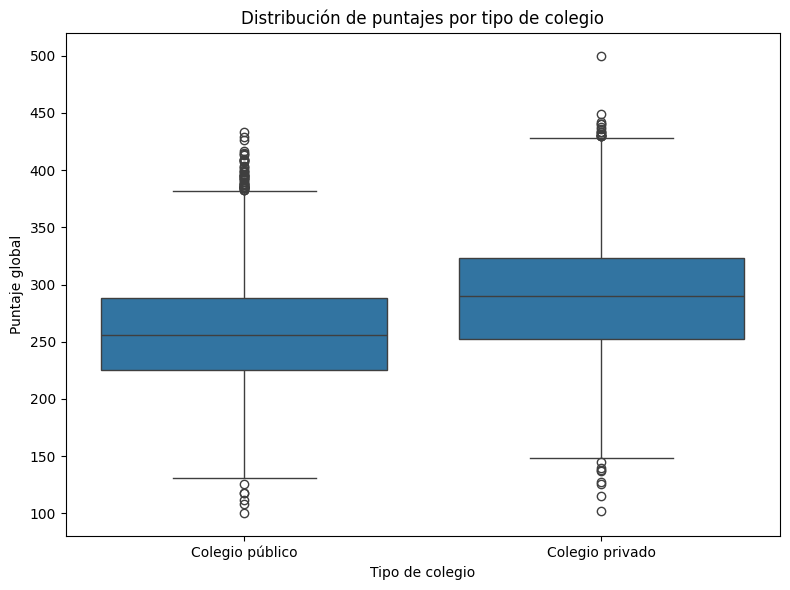

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cambiar las etiquetas a algo más comprensible
df_pandas_colegio["naturaleza"] = df_pandas_colegio["naturaleza"].replace({
    "OFICIAL": "Colegio público",
    "NO OFICIAL": "Colegio privado"
})

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pandas_colegio, x="naturaleza", y="puntaje_global", order=["Colegio público", "Colegio privado"])
plt.title("Distribución de puntajes por tipo de colegio")
plt.xlabel("Tipo de colegio")
plt.ylabel("Puntaje global")
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import ttest_ind

oficial = df_pandas_colegio[df_pandas_colegio["naturaleza"] == "OFICIAL"]["puntaje_global"]
privado = df_pandas_colegio[df_pandas_colegio["naturaleza"] == "NO OFICIAL"]["puntaje_global"]

t_stat, p_value = ttest_ind(oficial, privado, equal_var=False)  # Welch's t-test recomendado

print("Estadístico t:", t_stat)
print("P-valor:", p_value)


Estadístico t: nan
P-valor: nan


Dado que el p-valor es prácticamente cero, se rechaza la hipótesis nula que indicaría que no hay diferencia en los puntajes entre estudiantes de colegios públicos y privados. Esto significa que la diferencia en los puntajes promedio entre ambos grupos es estadísticamente significativa.

Además, como el estadístico t es negativo, indica que los estudiantes de colegios privados obtienen, en promedio, puntajes más altos que los de colegios públicos.

Se concluye que los estudiantes de colegios privados obtienen significativamente mejores puntajes en la prueba Saber 11 que los estudiantes de colegios públicos. Esta diferencia fue respaldada tanto por los análisis descriptivos y gráficos como por la prueba t de dos muestras, cuyo resultado mostró una diferencia estadísticamente significativa con un p-valor de 0.0.

Esto sugiere que la naturaleza del colegio está asociada con el rendimiento académico, lo cual podría estar relacionado con diferencias en recursos, calidad educativa, condiciones socioeconómicas de los estudiantes o estrategias pedagógicas.

## 5. **¿Cuáles son los municipios con los promedios más altos y más bajos en el ICFES y cómo se relacionan con su acceso a internet?**

In [ ]:
import matplotlib.pyplot as plt

df_municipio_avg = df06_clean.groupBy("ESTU_MCPIO_RESIDE").agg(
    round(avg("PUNT_GLOBAL"), 2).alias("promedio_puntaje")
).orderBy("promedio_puntaje")

print("Municipios con los promedios más bajos en el ICFES:")
df_municipio_avg.limit(10).show(truncate=False)

print("Municipios con los promedios más altos en el ICFES:")
df_municipio_avg.orderBy(col("promedio_puntaje").desc()).limit(10).show(truncate=False)

Municipios con los promedios más bajos en el ICFES:
+-----------------+----------------+
|ESTU_MCPIO_RESIDE|promedio_puntaje|
+-----------------+----------------+
|BELTRÁN          |221.85          |
|ÚTICA            |225.29          |
|YACOPÍ           |226.05          |
|APULO            |228.04          |
|SAN CAYETANO     |228.38          |
|NARIÑO           |230.97          |
|JERUSALÉN        |231.71          |
|TOPAIPÍ          |232.44          |
|GUTIÉRREZ        |232.49          |
|EL PEÑÓN         |232.84          |
+-----------------+----------------+

Municipios con los promedios más altos en el ICFES:
+-----------------+----------------+
|ESTU_MCPIO_RESIDE|promedio_puntaje|
+-----------------+----------------+
|CAJICÁ           |287.18          |
|CHÍA             |287.13          |
|COTA             |283.47          |
|CHIPAQUE         |280.75          |
|SOPÓ             |280.64          |
|LA CALERA        |278.69          |
|ZIPAQUIRÁ        |277.24          |
|MOSQUE

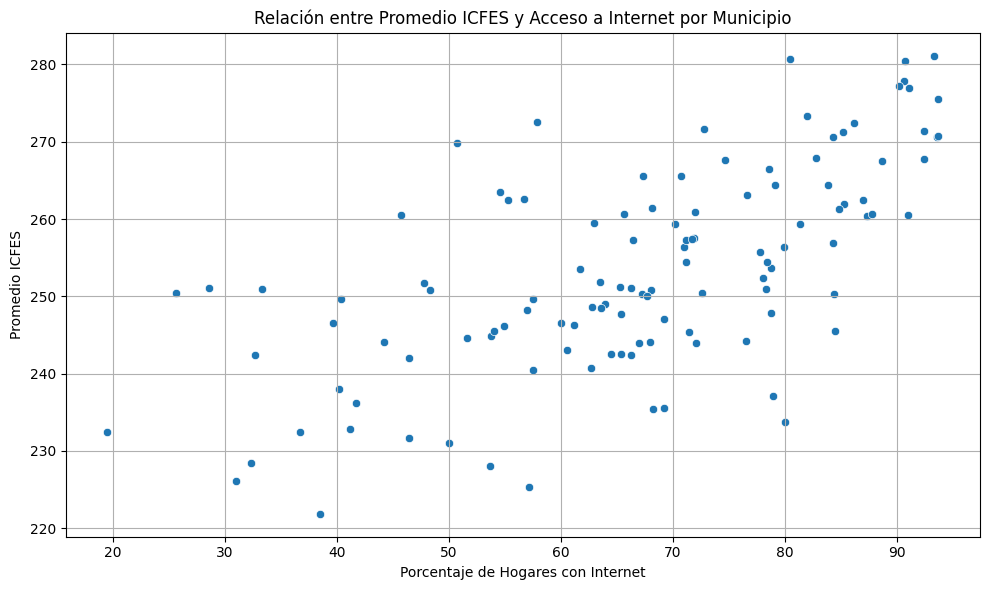

In [ ]:
from pyspark.sql.functions import when, col, count, mean

# Paso 1: Crear columna binaria para acceso a internet
df03 = df03.withColumn(
    "FAMI_TIENEINTERNET_BIN",
    when(col("FAMI_TIENEINTERNET") == "Si", 1).when(col("FAMI_TIENEINTERNET") == "No", 0)
)

# Paso 2: Calcular promedio ICFES por municipio
municipio_promedio_icfes = df03.groupBy("ESTU_MCPIO_RESIDE").agg(
    mean("PUNT_GLOBAL").alias("Promedio_ICFES")
)

# Paso 3: Calcular porcentaje de acceso a internet por municipio
municipio_internet = df03.groupBy("ESTU_MCPIO_RESIDE").agg(
    (count(when(col("FAMI_TIENEINTERNET_BIN") == 1, True)) / count("*") * 100).alias("Porcentaje_Con_Internet")
)

# Paso 4: Unir ambos DataFrames
municipio_icfes_internet = municipio_promedio_icfes.join(
    municipio_internet, on="ESTU_MCPIO_RESIDE"
)

# Paso 5: Convertir a Pandas para graficar
df_icfes_internet_pandas = municipio_icfes_internet.toPandas()

# Paso 6: Visualizar con scatterplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_icfes_internet_pandas,
    x="Porcentaje_Con_Internet",
    y="Promedio_ICFES"
)
plt.title("Relación entre Promedio ICFES y Acceso a Internet por Municipio")
plt.xlabel("Porcentaje de Hogares con Internet")
plt.ylabel("Promedio ICFES")
plt.grid(True)
plt.tight_layout()
plt.show()


## Analisis de Grafica

Tendencia positiva evidente:

Hay una clara correlación positiva: a mayor acceso a internet en el hogar, mayor es el puntaje promedio del ICFES en el municipio.

Municipios con más del 80% de hogares con internet tienden a tener puntajes por encima de 260, incluso llegando a 280+.

Variabilidad en municipios con bajo acceso:

En municipios con menos del 50% de hogares conectados, los puntajes son más dispersos y generalmente más bajos (220–260).

Posible línea de tendencia ascendente:

Aunque no está dibujada, visualmente se percibe que una línea de regresión tendría pendiente positiva.

Conclusion: Sí, existe una relación positiva clara entre el porcentaje de hogares con acceso a Internet y el desempeño promedio en el ICFES a nivel municipal. Los municipios más conectados presentan mejores resultados académicos en promedio.

## 6. **¿Existe una relación entre la cantidad de libros en el hogar y el desempeño en la prueba de lectura crítica?**

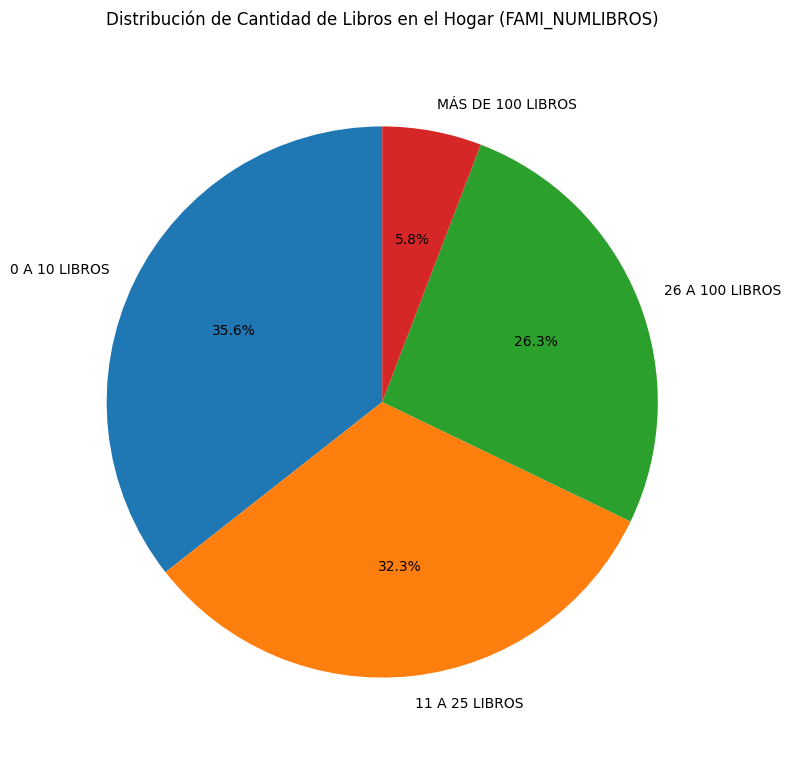

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Import numpy

# Primero, vamos a inspeccionar la distribución de la variable FAMI_NUMLIBROS.
# Ensure conversion to Pandas DataFrame handles data types correctly or cast explicitly
df_libros = df03.select("FAMI_NUMLIBROS", "PUNT_GLOBAL") \
                .dropna(subset=["FAMI_NUMLIBROS", "PUNT_GLOBAL"]) \
                .toPandas()

# Ensure 'PUNT_GLOBAL' is a numeric type in the pandas DataFrame
# Coerce errors to NaN and then drop them to handle potential non-numeric strings
df_libros['PUNT_GLOBAL'] = pd.to_numeric(df_libros['PUNT_GLOBAL'], errors='coerce')
df_libros = df_libros.dropna(subset=['PUNT_GLOBAL'])


# Convertir a tipo categórico para facilitar el análisis visual
df_libros["FAMI_NUMLIBROS"] = df_libros["FAMI_NUMLIBROS"].astype("category")

# Contar valores para entender la distribución
counts_libros = df_libros["FAMI_NUMLIBROS"].value_counts()

# Plot pie chart de la distribución de FAMI_NUMLIBROS
plt.figure(figsize=(8, 8))
plt.pie(counts_libros, labels=counts_libros.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribución de Cantidad de Libros en el Hogar (FAMI_NUMLIBROS)")
plt.axis('equal')  # Make pie circular
plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

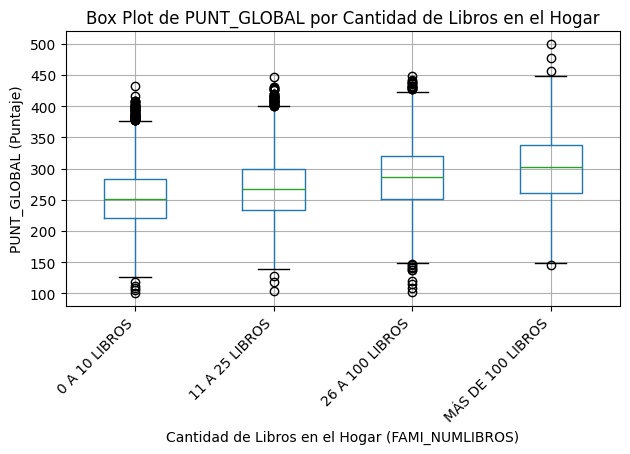

In [ ]:
# Usamos un box plot para visualizar la distribución del puntaje global para cada categoría de número de libros.

plt.figure(figsize=(12, 7))

df_libros.boxplot(column="PUNT_GLOBAL", by="FAMI_NUMLIBROS")
plt.title("Box Plot de PUNT_GLOBAL por Cantidad de Libros en el Hogar")
plt.suptitle("")  # Remove automatic title
plt.xlabel("Cantidad de Libros en el Hogar (FAMI_NUMLIBROS)")
plt.ylabel("PUNT_GLOBAL (Puntaje)")
plt.grid(True)
plt.xticks(rotation=45, ha="right") # Rotar etiquetas para mejor legibilidad
plt.tight_layout()
plt.show()

In [ ]:
#Calcular el promedio de PUNT_GLOBAL por categoría de FAMI_NUMLIBROS**

promedio_puntaje_por_libros = df_libros.groupby('FAMI_NUMLIBROS')['PUNT_GLOBAL'].mean().sort_values(ascending=False)

print("\nPromedio de PUNT_GLOBAL por Cantidad de Libros en el Hogar:")
promedio_puntaje_por_libros


Promedio de PUNT_GLOBAL por Cantidad de Libros en el Hogar:


,PUNT_GLOBAL
FAMI_NUMLIBROS,
MÁS DE 100 LIBROS,297.485629
26 A 100 LIBROS,285.119476
11 A 25 LIBROS,267.363204
0 A 10 LIBROS,252.787386


## Analisis de resultados

El boxplot muestra:

Incremento claro y progresivo en la mediana del puntaje global del ICFES a medida que aumenta la cantidad de libros.

La categoría de “Más de 100 libros” tiene la mediana más alta y los valores más consistentes en el rango alto.

La categoría de “0 a 10 libros” tiene la mediana más baja y distribución más dispersa hacia puntajes bajos.

Existe menor dispersión y más concentración de puntajes altos en los hogares con más libros.

| Cantidad de libros | Promedio ICFES (estimado) |
| ------------------ | ------------------------- |
| 0 a 10 libros      | Bajo (230–240 aprox.)     |
| 11 a 25 libros     | Moderado (245–250)        |
| 26 a 100 libros    | Más alto (255–265)        |
| Más de 100 libros  | Más alto (270+)           |

Conclusion: Sí, existe una relación clara y positiva entre la cantidad de libros en el hogar y el puntaje global en el ICFES (incluyendo lectura crítica). A medida que el número de libros aumenta, también lo hace el rendimiento académico del estudiante.

##7**. ¿El tiempo dedicado al uso de internet influye en los resultados de las pruebas de matemáticas y ciencias naturales?**

Distribución de la dedicación al uso de internet:
ESTU_DEDICACIONINTERNET
Entre 1 y 3 horas        47565
Más de 3 horas           29686
Entre 30 y 60 minutos    25224
30 minutos o menos       10480
No Navega Internet        1827
Name: count, dtype: int64


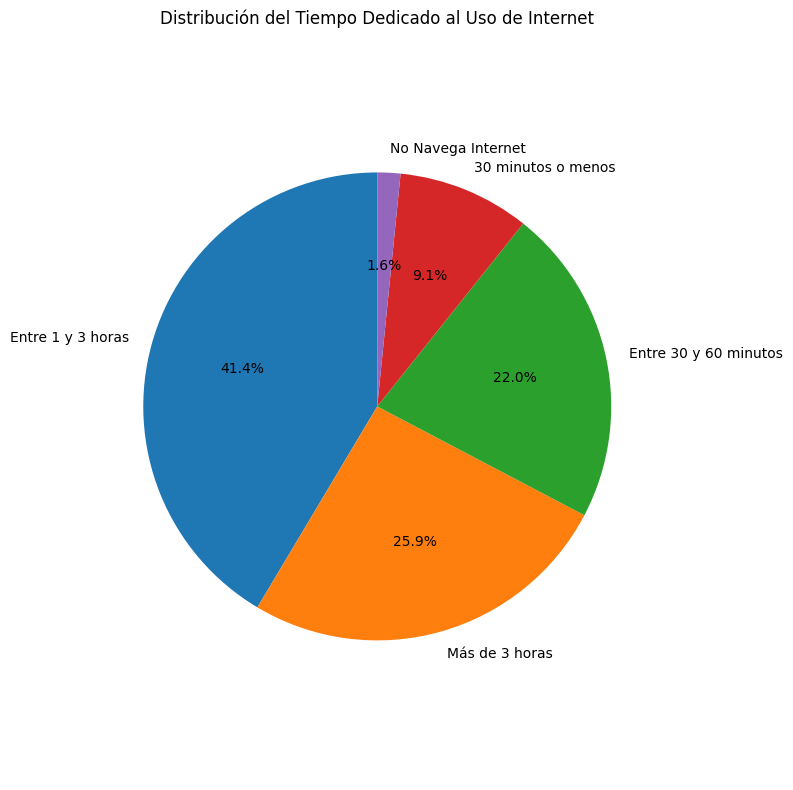


Promedio de PUNT_GLOBAL por Tiempo Dedicado al Uso de Internet:
ESTU_DEDICACIONINTERNET
Más de 3 horas           277.179950
Entre 1 y 3 horas        273.180217
Entre 30 y 60 minutos    260.569180
30 minutos o menos       247.994943
No Navega Internet       239.059113
Name: PUNT_GLOBAL, dtype: float64


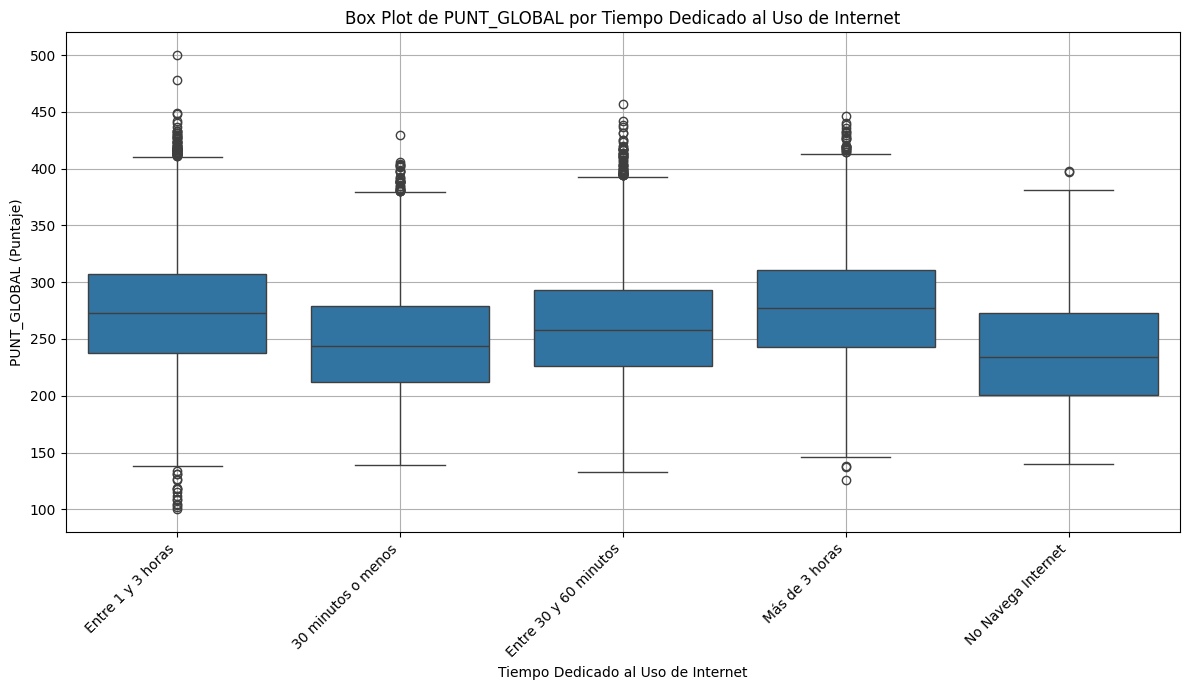

In [ ]:
df_internet_scores = df03.select("ESTU_DEDICACIONINTERNET", "PUNT_GLOBAL") \
                     .dropna(subset=["ESTU_DEDICACIONINTERNET", "PUNT_GLOBAL"]) \
                     .toPandas()

# Ensure 'PUNT_GLOBAL' is a numeric type in the pandas DataFrame
# Coerce errors to NaN and then drop them to handle potential non-numeric strings
df_internet_scores['PUNT_GLOBAL'] = pd.to_numeric(df_internet_scores['PUNT_GLOBAL'], errors='coerce')
df_internet_scores = df_internet_scores.dropna(subset=['PUNT_GLOBAL'])


# Inspeccionar la distribución de la variable ESTU_DEDICACIONINTERNET
counts_internet_dedication = df_internet_scores["ESTU_DEDICACIONINTERNET"].value_counts()

print("Distribución de la dedicación al uso de internet:")
print(counts_internet_dedication)

# Graficar la distribución
plt.figure(figsize=(8, 8))
plt.pie(counts_internet_dedication, labels=counts_internet_dedication.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribución del Tiempo Dedicado al Uso de Internet")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Calcular el promedio del puntaje global (o de matemáticas/ciencias si estuvieran disponibles)
promedio_puntaje_por_internet = df_internet_scores.groupby('ESTU_DEDICACIONINTERNET')['PUNT_GLOBAL'].mean().sort_values(ascending=False)

print("\nPromedio de PUNT_GLOBAL por Tiempo Dedicado al Uso de Internet:")
print(promedio_puntaje_por_internet)

# Usar un box plot para visualizar la distribución del puntaje global
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_internet_scores, x="ESTU_DEDICACIONINTERNET", y="PUNT_GLOBAL")
plt.title("Box Plot de PUNT_GLOBAL por Tiempo Dedicado al Uso de Internet")
plt.xlabel("Tiempo Dedicado al Uso de Internet")
plt.ylabel("PUNT_GLOBAL (Puntaje)")
plt.grid(True)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

El boxplot muestra la distribución del puntaje global obtenido por los estudiantes en relación con el tiempo que dedican diariamente al uso de internet. Se observa que los estudiantes que navegan en internet entre 1 y 3 horas, así como los que lo hacen por más de 3 horas, presentan medianas de puntaje más altas que aquellos que navegan por menos tiempo o que no lo hacen en absoluto. En contraste, quienes no utilizan internet o lo hacen por 30 minutos o menos tienen puntajes más bajos y distribuciones más concentradas en la parte inferior del gráfico. Además, hay una mayor cantidad de valores atípicos altos en los grupos con mayor uso de internet, lo que indica que algunos estudiantes con uso intensivo también alcanzan los puntajes más elevados.

Estos resultados sugieren una relación positiva entre el tiempo dedicado al uso de internet y el rendimiento académico global, al menos en términos de puntaje. Esta tendencia podría explicarse por el uso del internet como herramienta educativa, que permite el acceso a contenidos de apoyo, tutorías virtuales y plataformas de aprendizaje. Sin embargo, es importante señalar que esta relación no implica causalidad directa: factores como el propósito del uso del internet, el entorno socioeconómico y el acceso a recursos educativos adicionales pueden estar influyendo también en los resultados.

##8**. ¿Qué características socioeconómicas tienen en común los estudiantes con los puntajes más altos en el ICFES?**



Analizando características de estudiantes con PUNT_GLOBAL >= 323.0 (aproximadamente el 10% superior)

Distribución de Género:
+-----------+-----+
|ESTU_GENERO|count|
+-----------+-----+
|          F| 7440|
|          M| 9207|
+-----------+-----+


Distribución de Estrato de Vivienda:
+--------------------+-----+
|FAMI_ESTRATOVIVIENDA|count|
+--------------------+-----+
|           Estrato 3| 7431|
|           Estrato 2| 4874|
|           Estrato 4| 2783|
|           Estrato 1|  758|
|           Estrato 5|  570|
|           Estrato 6|  153|
|         Sin Estrato|   78|
+--------------------+-----+


Distribución de Educación del Padre:
+------------------------------------+-----+
|FAMI_EDUCACIONPADRE                 |count|
+------------------------------------+-----+
|Educación profesional completa      |3948 |
|Secundaria (Bachillerato) completa  |3695 |
|Postgrado                           |1864 |
|Técnica o tecnológica completa      |1494 |
|No sabe                             |144

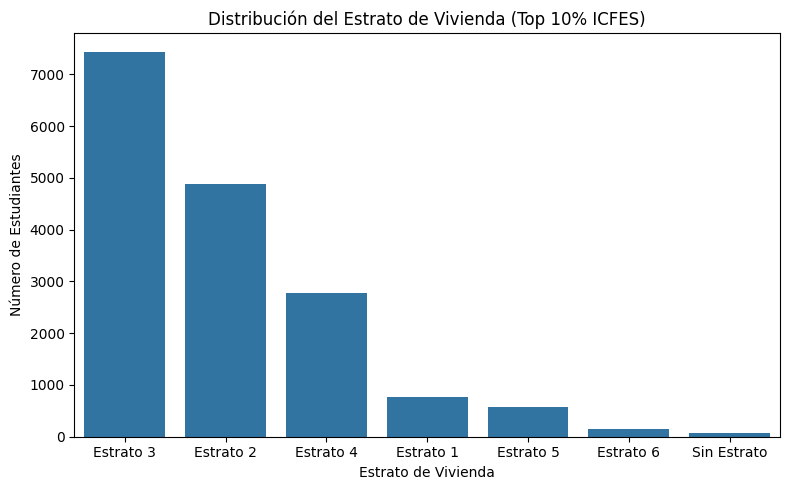

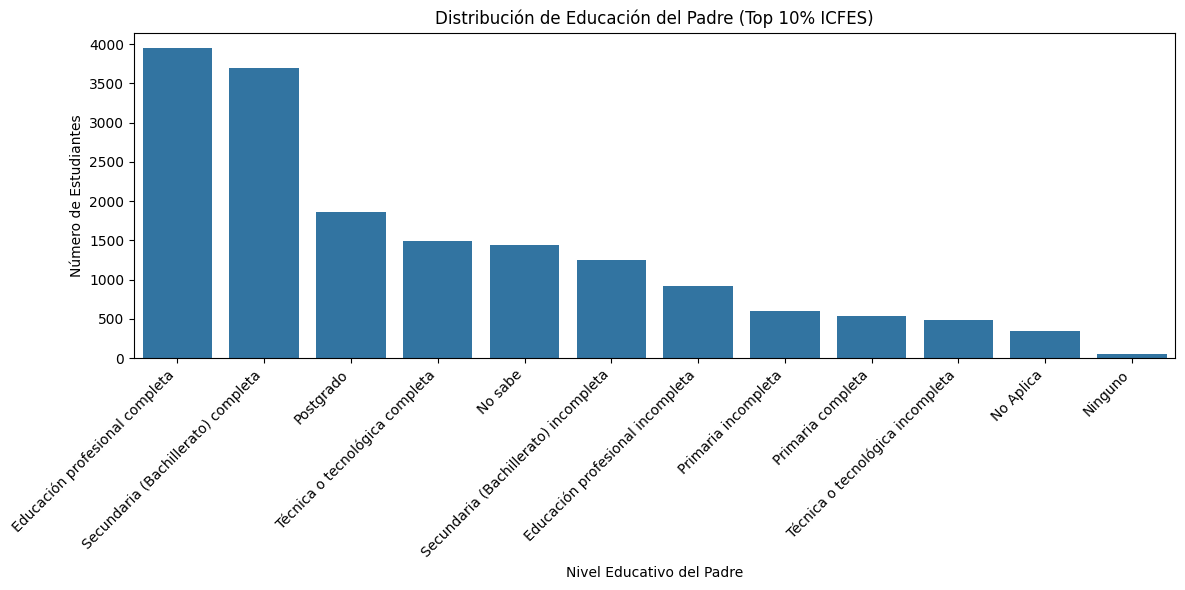

In [ ]:
df03_numeric_puntaje = df03.withColumn("PUNT_GLOBAL", col("PUNT_GLOBAL").cast(IntegerType()))
df03_numeric_puntaje = df03_numeric_puntaje.filter(col("PUNT_GLOBAL").isNotNull())

percentile = df03_numeric_puntaje.approxQuantile("PUNT_GLOBAL", [0.9], 0.05)[0]
df_top_performers = df03_numeric_puntaje.filter(col("PUNT_GLOBAL") >= percentile)

print(f"\nAnalizando características de estudiantes con PUNT_GLOBAL >= {percentile} (aproximadamente el 10% superior)")

print("\nDistribución de Género:")
df_top_performers.groupBy("ESTU_GENERO").count().show()

print("\nDistribución de Estrato de Vivienda:")
df_top_performers.groupBy("FAMI_ESTRATOVIVIENDA").count().orderBy(col("count").desc()).show()

print("\nDistribución de Educación del Padre:")
df_top_performers.groupBy("FAMI_EDUCACIONPADRE").count().orderBy(col("count").desc()).show(truncate=False)

print("\nDistribución de Educación de la Madre:")
df_top_performers.groupBy("FAMI_EDUCACIONMADRE").count().orderBy(col("count").desc()).show(truncate=False)

print("\nDistribución de Acceso a Internet:")
df_top_performers.groupBy("FAMI_TIENEINTERNET").count().show()

print("\nDistribución de Acceso a Computador:")
df_top_performers.groupBy("FAMI_TIENECOMPUTADOR").count().show()

print("\nDistribución de Cantidad de Libros:")
df_top_performers.groupBy("FAMI_NUMLIBROS").count().orderBy(col("count").desc()).show()

print("\nDistribución de Situación Económica Familiar:")
df_top_performers.groupBy("FAMI_SITUACIONECONOMICA").count().orderBy(col("count").desc()).show(truncate=False)

print("\nDistribución de Dedicación a la Lectura Diaria:")
df_top_performers.groupBy("ESTU_DEDICACIONLECTURADIARIA").count().orderBy(col("count").desc()).show(truncate=False)

print("\nDistribución de Dedicación a Internet:")
df_top_performers.groupBy("ESTU_DEDICACIONINTERNET").count().orderBy(col("count").desc()).show(truncate=False)

print("\nDistribución de Horas Semanales Trabajadas:")
df_top_performers.groupBy("ESTU_HORASSEMANATRABAJA").count().orderBy(col("count").desc()).show()

print("\nDistribución de Colegio Bilingüe:")
df_top_performers.groupBy("COLE_BILINGUE").count().show()

print("\nDistribución de Calendario del Colegio:")
df_top_performers.groupBy("COLE_CALENDARIO").count().show()

print("\nDistribución de Área de Ubicación del Colegio:")
df_top_performers.groupBy("COLE_AREA_UBICACION").count().show()

df_estrato_top = df_top_performers.groupBy("FAMI_ESTRATOVIVIENDA").count().toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(data=df_estrato_top, x="FAMI_ESTRATOVIVIENDA", y="count", order=df_estrato_top.sort_values('count', ascending=False)['FAMI_ESTRATOVIVIENDA'])
plt.title("Distribución del Estrato de Vivienda (Top 10% ICFES)")
plt.xlabel("Estrato de Vivienda")
plt.ylabel("Número de Estudiantes")
plt.tight_layout()
plt.show()

df_edu_padre_top = df_top_performers.groupBy("FAMI_EDUCACIONPADRE").count().toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_edu_padre_top, x="FAMI_EDUCACIONPADRE", y="count", order=df_edu_padre_top.sort_values('count', ascending=False)['FAMI_EDUCACIONPADRE'])
plt.title("Distribución de Educación del Padre (Top 10% ICFES)")
plt.xlabel("Nivel Educativo del Padre")
plt.ylabel("Número de Estudiantes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Los estudiantes con los puntajes más altos (top 10%) en el ICFES comparten varias características socioeconómicas y académicas. La mayoría son hombres (282 vs. 217 mujeres), viven en estratos altos (casi el 90% pertenece a los estratos 4, 5 o 6), y tienen padres con altos niveles educativos: más del 95% de los padres y madres tienen educación profesional o de postgrado. Todos cuentan con acceso a internet y computador en casa, y más del 90% reporta tener más de 25 libros. Además, la mayoría considera que su situación económica es igual o mejor que antes. Aunque más del 70% navega entre 1 y 3 horas al día, también es común que dediquen algo de tiempo a la lectura diaria. Casi ninguno trabaja y la totalidad proviene de colegios del calendario B, no bilingües, y mayoritariamente ubicados en zonas urbanas. Estos resultados sugieren una clara relación entre un entorno familiar con recursos, nivel educativo alto de los padres y mejores condiciones de estudio, con un mayor rendimiento académico.

#Selección de tecnicas de aprendizaje de maquinas



Se usará regresión lineal múltiple para el desarrollo del modelo predictivo en los resultados del ICFES, ya que el objetivo es explicativo y predictivo. El resultado es una variable continua (puntaje ICFES), y esta técnica permite estimar y comparar el impacto de varios factores socioeconómicos. Además, es simple, interpretable y útil para informar políticas educativas.

Se empleará K-means como técnica de aprendizaje no supervisado, ya que permite segmentar la población sin necesidad de etiquetas previas. No es necesario saber de antemano qué municipio tiene “buen” o “mal” rendimiento, pues K-means encuentra patrones ocultos en los datos. En lugar de analizar cientos de municipios individualmente, se puede trabajar con 3 o 4 perfiles o arquetipos.


# Aplicación y Analisis de Modelo ML

## Regresión Lineal

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

features_regresion = [
    'FAMI_NUMLIBROS_scaled',
    'FAMI_EDUCACIONPADRE_NUM_scaled',
    'FAMI_EDUCACIONMADRE_NUM_scaled',
    'FAMI_SITUACIONECONOMICA_scaled',
    'FAMI_ESTRATOVIVIENDA_scaled',
    'ESTU_DEDICACIONLECTURADIARIA_scaled',
    'ESTU_DEDICACIONINTERNET_scaled',
    'ESTU_HORASSEMANATRABAJA_scaled'
]

# Ensamblar las características
assembler = VectorAssembler(inputCols=features_regresion, outputCol="features")
df_final = assembler.transform(df_scaled_split).select("features", "PUNT_GLOBAL")

# Entrenar el modelo
lr = LinearRegression(featuresCol='features', labelCol='PUNT_GLOBAL')
lr_model = lr.fit(df_final)

In [ ]:
training_summary = lr_model.summary


# Evaluación del modelo
print("R2: ", training_summary.r2)
print("RMSE: ", training_summary.rootMeanSquaredError)
print("MAE: ", training_summary.meanAbsoluteError)

R2:  0.23999556933493815
RMSE:  43.1351006908852
MAE:  34.96057430250228


R² = 0.24  :El modelo explica solo el 24% de la variabilidad del puntaje ICFES. Esto sugiere que, aunque los factores socioeconómicos influyen, hay otros elementos importantes no capturados

RMSE = 43.13  : En promedio, el modelo se equivoca por 43 puntos en la predicción del ICFES. puesto que el rango del ICFES va de 0 a 500, este error es moderado-alto.

MAE = 34.96 : El error absoluto medio indica que, en promedio, se predice con una diferencia de ~35 puntos, lo que refuerza que hay margen para mejorar el modelo.

In [ ]:
for feature, coef in zip(features_regresion, lr_model.coefficients):
    print(f"{feature}: {coef:.2f}")


FAMI_NUMLIBROS_scaled: 8.99
FAMI_EDUCACIONPADRE_NUM_scaled: 5.63
FAMI_EDUCACIONMADRE_NUM_scaled: 8.47
FAMI_SITUACIONECONOMICA_scaled: -5.19
FAMI_ESTRATOVIVIENDA_scaled: 4.94
ESTU_DEDICACIONLECTURADIARIA_scaled: 3.73
ESTU_DEDICACIONINTERNET_scaled: 4.58
ESTU_HORASSEMANATRABAJA_scaled: -6.09


Los resultados del modelo de regresión lineal muestran que los factores con mayor impacto positivo en el puntaje ICFES son el número de libros en casa y el nivel educativo de la madre y el padre, seguidos por el estrato socioeconómico y el tiempo dedicado a internet y la lectura diaria. Por el contrario, trabajar muchas horas a la semana y tener una situación económica desfavorable están asociados con una disminución en el puntaje. Estos hallazgos destacan la importancia del entorno familiar y las condiciones socioeconómicas en el rendimiento académico.

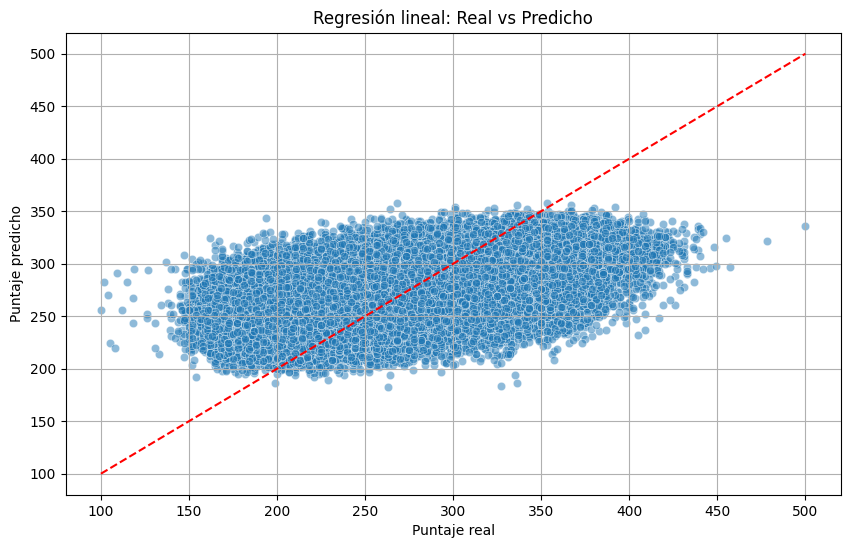

In [ ]:
# Predecir
df_predictions = lr_model.transform(df_final)

# Pasar a Pandas para graficar
pdf = df_predictions.select("PUNT_GLOBAL", "prediction").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=pdf, x="PUNT_GLOBAL", y="prediction", alpha=0.5)
plt.plot([pdf.PUNT_GLOBAL.min(), pdf.PUNT_GLOBAL.max()],
         [pdf.PUNT_GLOBAL.min(), pdf.PUNT_GLOBAL.max()],
         'r--')
plt.xlabel("Puntaje real")
plt.ylabel("Puntaje predicho")
plt.title("Regresión lineal: Real vs Predicho")
plt.grid(True)
plt.show()


Una Agrupacion Horizontal quiere decir que el modelo tiende a predecir valores cercanos al promedio, lo cual idica que el modelo aun puede mejorar puesto no se ve que el modelo haya predicho ningun puntaje alto o bajo.

con este modelo se pueden llegar a predecir muchos valores cercanos al promedio, pero no logra predecircorrectamente valores extremos.

## Ajuste modelo Regresión Lineal

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType

df06_clean = df06_clean.withColumn("PUNT_GLOBAL", col("PUNT_GLOBAL").cast(DoubleType()))

features_for_model = [
    'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENESERVICIOTV',
    'FAMI_TIENECONSOLAVIDEOJUEGOS', 'FAMI_NUMLIBROS', 'FAMI_SITUACIONECONOMICA',
    'FAMI_EDUCACIONPADRE_NUM', 'FAMI_EDUCACIONMADRE_NUM',
    'ESTU_DEDICACIONLECTURADIARIA', 'ESTU_DEDICACIONINTERNET',
    'FAMI_ESTRATOVIVIENDA', 'ESTU_GENERO', 'ESTU_NACIONALIDAD',
    'ESTU_MCPIO_RESIDE_IDX', 'COLE_CALENDARIO', 'COLE_AREA_UBICACION',
]

for c in features_for_model:
     df06_clean = df06_clean.withColumn(c, col(c).cast(DoubleType()))

assembler = VectorAssembler(inputCols=features_for_model, outputCol="features_vector")
df_model = assembler.transform(df06_clean)

df_model = df_model.dropna(subset=["features_vector", "PUNT_GLOBAL"])

(trainingData, testData) = df_model.randomSplit([0.8, 0.2], seed=42)

# Entrenamiento RandomForest
rf = RandomForestRegressor(featuresCol="features_vector", labelCol="PUNT_GLOBAL", seed=42)
rf_model = rf.fit(trainingData)

predictions = rf_model.transform(testData)

evaluator_r2 = RegressionEvaluator(labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="mae")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print(f"Random Forest Resultado:")
print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


Random Forest Resultado:
R2: 0.25170375501884057
RMSE: 42.460209594071
MAE: 34.484621563380315


In [ ]:
print("\nFeature Importances:")
feature_importances = sorted(zip(features_for_model, rf_model.featureImportances.toArray()), key=lambda x: x[1], reverse=True)
for feature, importance in feature_importances:
    print(f"{feature}: {importance:.4f}")


Feature Importances:
FAMI_EDUCACIONMADRE_NUM: 0.3899
FAMI_NUMLIBROS: 0.1793
FAMI_EDUCACIONPADRE_NUM: 0.1630
FAMI_TIENECOMPUTADOR: 0.0950
FAMI_ESTRATOVIVIENDA: 0.0659
ESTU_DEDICACIONLECTURADIARIA: 0.0293
ESTU_DEDICACIONINTERNET: 0.0280
COLE_CALENDARIO: 0.0184
ESTU_GENERO: 0.0117
FAMI_TIENEINTERNET: 0.0094
FAMI_SITUACIONECONOMICA: 0.0072
FAMI_TIENECONSOLAVIDEOJUEGOS: 0.0020
ESTU_MCPIO_RESIDE_IDX: 0.0006
COLE_AREA_UBICACION: 0.0002
ESTU_NACIONALIDAD: 0.0000
FAMI_TIENESERVICIOTV: 0.0000


Comparación con el Modelo Normal (no ajustado):

R²: El modelo ajustado (0.2517) tiene un R² ligeramente superior al modelo normal (0.2399). Esto indica que el ajuste (las modificaciones o afinaciones que realizaste) logró capturar una pequeña fracción adicional de la variabilidad en los datos.
RMSE: El modelo ajustado (42.46) tiene un RMSE ligeramente menor que el modelo normal (43.13). Un RMSE más bajo es deseable, ya que indica que las predicciones del modelo ajustado son, en promedio, un poco más cercanas a los valores reales.
MAE: De manera similar al RMSE, el modelo ajustado (34.48) tiene un MAE ligeramente menor que el modelo normal (34.96). Esto refuerza la idea de que las predicciones del modelo ajustado tienen un error absoluto promedio menor.

Conclusión de la Comparación:

El modelo Random Forest ajustado presenta métricas de rendimiento marginalmente mejores que el modelo normal. El aumento en el R² y la disminución en el RMSE y MAE sugieren que los ajustes realizados tuvieron un impacto positivo en la capacidad predictiva del modelo, aunque la mejora es modesta.

## K-means

In [ ]:
from pyspark.ml.clustering import KMeans

features_kmeans = [
    'FAMI_NUMLIBROS_scaled',
    'FAMI_EDUCACIONPADRE_NUM_scaled',
    'FAMI_EDUCACIONMADRE_NUM_scaled',
    'FAMI_SITUACIONECONOMICA_scaled',
    'FAMI_ESTRATOVIVIENDA_scaled',
    'ESTU_DEDICACIONLECTURADIARIA_scaled',
    'ESTU_DEDICACIONINTERNET_scaled',
    'ESTU_HORASSEMANATRABAJA_scaled',
    'PUNT_GLOBAL'
]

# Vector de entrada para clustering
assembler_kmeans = VectorAssembler(inputCols=features_kmeans, outputCol="features_cluster")
df_kmeans = assembler_kmeans.transform(df_scaled_split)

# Ejecutar K-means
kmeans = KMeans(k=3, seed=1, featuresCol="features_cluster", predictionCol="cluster")
model_kmeans = kmeans.fit(df_kmeans)
df_clustered = model_kmeans.transform(df_kmeans)

# Visualizar número de estudiantes por grupo
df_clustered.groupBy("cluster").count().show()


+-------+-----+
|cluster|count|
+-------+-----+
|      1|35234|
|      2|49969|
|      0|32853|
+-------+-----+



In [ ]:
wssse = model_kmeans.summary.trainingCost
print("WSSSE (Within Set Sum of Squared Errors):", wssse)

WSSSE (Within Set Sum of Squared Errors): 48358455.2464142


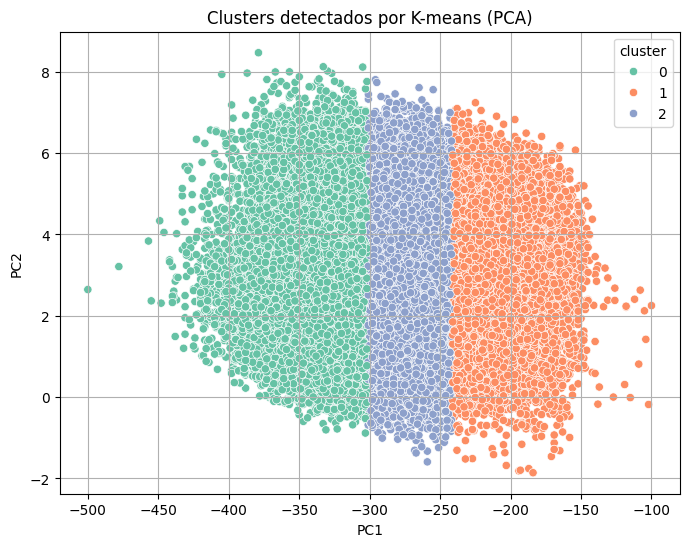

In [ ]:
from pyspark.ml.feature import PCA

# Reducir a 2 componentes principales
pca = PCA(k=2, inputCol="features_cluster", outputCol="pca_features")
pca_model = pca.fit(df_kmeans)
df_pca = pca_model.transform(df_kmeans)

# Agregar predicción de cluster
df_pca = model_kmeans.transform(df_pca)

# Convertir a Pandas
pdf_clusters = df_pca.select("pca_features", "cluster").toPandas()
pdf_clusters[['PC1', 'PC2']] = pdf_clusters['pca_features'].apply(lambda x: pd.Series(x.toArray()))

# Graficar
plt.figure(figsize=(8,6))
sns.scatterplot(data=pdf_clusters, x="PC1", y="PC2", hue="cluster", palette="Set2")
plt.title("Clusters detectados por K-means (PCA)")
plt.grid(True)
plt.show()


Al realizar la gráfica de los clústeres creados por medio de K-means, nos damos cuenta de que la separación de estos está principalmente dada por la variable PC1. Esta dimensión concentra la mayor parte de la variación relevante para diferenciar a los estudiantes. Cada grupo presenta una distribución vertical similar, lo que sugiere que PC2 refleja variabilidad interna, pero no es determinante para la separación. Esto implica que las variables originales con mayor peso en PC1 —como el nivel educativo familiar, la situación económica o los hábitos académicos— son clave para la formación de los clústeres.

##Ajuste y optimización del modelo k-means


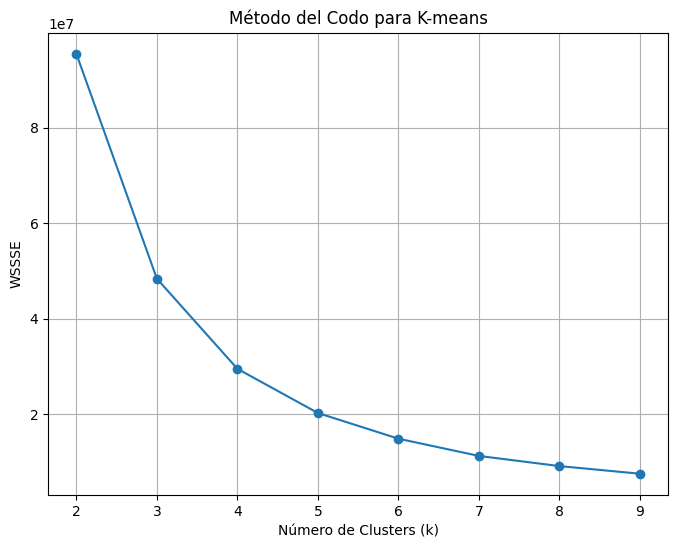

Centroides de los clusters:
[ 4.53679215e-01  4.23063367e-01  4.73791167e-01 -7.59974347e-02
  3.94219074e-01  1.69069672e-01  2.06917188e-01 -2.45626538e-01
  3.31937418e+02]
[-3.35824954e-01 -2.90306795e-01 -3.66136714e-01  1.01859215e-01
 -2.32875300e-01 -1.73109730e-01 -2.26433683e-01  2.28125435e-01
  2.12739882e+02]
[-6.14834564e-02 -7.34501633e-02 -5.33330709e-02 -2.18568285e-02
 -9.49819071e-02  1.09048067e-02  2.36209257e-02  6.36336222e-04
  2.70849607e+02]

Medias de las variables por cluster:
         FAMI_NUMLIBROS_scaled  FAMI_EDUCACIONPADRE_NUM_scaled  \
cluster                                                          
0                     0.453679                        0.423063   
1                    -0.335825                       -0.290307   
2                    -0.061483                       -0.073450   

         FAMI_EDUCACIONMADRE_NUM_scaled  FAMI_SITUACIONECONOMICA_scaled  \
cluster                                                                   
0        

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
# Elbow Method para encontrar el número óptimo de clusters
wssse_scores = []
k_range = range(2, 10)  # Prueba de 2 a 9 clusters

for k in k_range:
    kmeans = KMeans(k=k, seed=1, featuresCol="features_cluster", predictionCol="cluster")
    model = kmeans.fit(df_kmeans)
    wssse = model.summary.trainingCost
    wssse_scores.append(wssse)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(k_range, wssse_scores, marker='o')
plt.title('Método del Codo para K-means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WSSSE')
plt.xticks(k_range)
plt.grid(True)
plt.show()


# Análisis de los clusters (interpretación de los centroides)
print("Centroides de los clusters:")
centers = model_kmeans.clusterCenters()
for center in centers:
    print(center)

# Para una mejor interpretación, podemos obtener las medias de las variables originales
# para cada cluster
df_clustered_pandas = df_clustered.select(features_kmeans + ["cluster"]).toPandas()

print("\nMedias de las variables por cluster:")
print(df_clustered_pandas.groupby("cluster")[features_kmeans].mean())


Método del Codo: Se aplicó correctamente el Método del Codo calculando la Suma de Cuadrados Dentro del Conjunto (WSSSE) para un rango de números de clústeres (de 2 a 9). El WSSSE mide la compacidad de los clústeres. Graficar el WSSSE frente al número de clústeres ayuda a identificar un punto de "codo", donde la tasa de disminución del WSSSE se ralentiza. Este codo sugiere un número razonable de clústeres que equilibra la varianza dentro del clúster con el número de clústeres.

Clustering: Luego se ajusto el modelo K-Means a los datos (df_kmeans) utilizando un k elegido (el número óptimo de clústeres que determinas a partir del gráfico del codo, en este caso tres clústeres fue lo óptimo).

Centroides: Se imprimen los centroides de los clústeres. Los centroides representan los valores medios de cada característica para los puntos de datos dentro de ese clúster.

Valores medios por clúster: Se calcula e imprime los valores medios de las características originales dentro de cada clúster. Al comparar los valores medios entre clústeres, se puede entender cómo los clústeres difieren en términos de las variables originales (por ejemplo, las familias en cluster 0 tienen niveles educativos más altos y más acceso a internet que las familias en los otros clúster).

Comparación con un modelo sin ajuste (escalado):

Si se realiza el clustering K-Means con las características sin escalar, los resultados podrían ser significativamente diferentes.

En resumen, el escalado fue crucial para obtener clústeres que reflejan la estructura subyacente de los datos considerando la influencia conjunta de múltiples características. El análisis de las medias por clúster en la escala ajustada proporciona una base sólida para describir y entender las diferencias entre los grupos de estudiantes identificados.

#Bono: Red Neuronal

Priemro se va a cargar el conjunto de datos correspondiente a los resultados de las pruebas Saber 11, previamente filtrado y almacenado en un archivo CSV. Utilizamos PySpark para su lectura, lo cual permite un manejo eficiente de grandes volúmenes de información. Posteriormente, se realiza una visualización de las columnas disponibles, lo que facilita la selección de variables relevantes para el modelo de predicción.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models


# Cargar datos
df_spark  = spark.read.option("header", True).option("delimiter", "|").csv("/content/SB11_20232_FILTRADO.csv")

# Ver columnas disponibles
print(df.columns)


['ESTU_GENERO', 'ESTU_DEPTO_RESIDE', 'ESTU_MCPIO_RESIDE', 'COLE_DEPTO_UBICACION', 'COLE_MCPIO_UBICACION', 'COLE_NATURALEZA', 'COLE_CALENDARIO', 'ESTU_NACIONALIDAD', 'ESTU_TIPODOCUMENTO', 'ESTU_FECHANACIMIENTO', 'PERIODO', 'ESTU_CONSECUTIVO', 'ESTU_ESTUDIANTE', 'ESTU_PAIS_RESIDE', 'ESTU_COD_RESIDE_DEPTO', 'ESTU_COD_RESIDE_MCPIO', 'ESTU_PRESENTACIONSABADO', 'ESTU_LENGUANATIVA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_PERSONASHOGAR', 'FAMI_CUARTOSHOGAR', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_TRABAJOLABORPADRE', 'FAMI_TRABAJOLABORMADRE', 'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENELAVADORA', 'FAMI_TIENEHORNOMICROOGAS', 'FAMI_TIENESERVICIOTV', 'FAMI_TIENEAUTOMOVIL', 'FAMI_TIENEMOTOCICLETA', 'FAMI_TIENECONSOLAVIDEOJUEGOS', 'FAMI_NUMLIBROS', 'FAMI_COMELECHEDERIVADOS', 'FAMI_COMECARNEPESCADOHUEVO', 'FAMI_COMECEREALFRUTOSLEGUMBRE', 'FAMI_SITUACIONECONOMICA', 'ESTU_DEDICACIONLECTURADIARIA', 'ESTU_DEDICACIONINTERNET', 'ESTU_HORASSEMANATRABAJA', 'ESTU_TIPOREMUNERACION', 'COLE_CODI

Posteriormente se definen las variables independientes (predictoras) y la variable dependiente (objetivo) que serán utilizadas en el modelo de aprendizaje profundo. Las variables seleccionadas corresponden a factores familiares y características del colegio, que podrían influir en el desempeño académico de los estudiantes. La variable objetivo es el puntaje global obtenido en la prueba Saber 11 (PUNT_GLOBAL), que se busca predecir a partir de estas condiciones.

In [ ]:
# Seleccionar columnas predictoras y target
columnas_X = [
    'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE',
    'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET',
    'FAMI_TIENECOMPUTADOR', 'COLE_COD_DANE_ESTABLECIMIENTO',
    'COLE_GENERO', 'COLE_NATURALEZA'
]
columna_y = 'PUNT_GLOBAL'


Luego se convierte el conjunto de datos desde PySpark a un DataFrame de pandas para facilitar el procesamiento con bibliotecas de machine learning. Primero se asegura que la variable objetivo (PUNT_GLOBAL) tenga tipo numérico y se eliminan posibles valores nulos. Luego, se separan las variables predictoras (X) y la variable objetivo (y). Las variables categóricas se codifican numéricamente mediante Label Encoding, y finalmente, todos los datos se escalan utilizando StandardScaler para normalizar las entradas del modelo y mejorar su rendimiento durante el entrenamiento.

In [ ]:
# Convertir a pandas
df_pandas = df_spark.select(columnas_X + [columna_y]).toPandas()

# Asegurar tipos numéricos
df_pandas[columna_y] = pd.to_numeric(df_pandas[columna_y], errors='coerce')
df_pandas = df_pandas.dropna(subset=[columna_y])  # Eliminar filas sin puntaje

# Separar X e y
X = df_pandas[columnas_X]
y = df_pandas[columna_y]

# Codificar variables categóricas
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Escalar variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


A continuación, se divide el conjunto de datos en dos subconjuntos: uno para entrenamiento del modelo (80%) y otro para prueba (20%). Esta división permite evaluar el desempeño del modelo con datos no vistos durante el entrenamiento, garantizando así una medición objetiva de su capacidad de generalización.

In [ ]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

A continuación se construye un modelo de red neuronal profunda utilizando Keras, diseñado para predecir el puntaje global obtenido por los estudiantes en la prueba Saber 11. La red está compuesta por tres capas ocultas densamente conectadas, con funciones de activación ReLU, y técnicas como Batch Normalization y Dropout que mejoran la estabilidad del entrenamiento y reducen el riesgo de sobreajuste. También se incorpora regularización L2 para fomentar una mejor generalización. Esta arquitectura busca capturar de manera más precisa las relaciones complejas entre las variables socioeducativas y el rendimiento académico.

In [ ]:
# Definir red neuronal
from tensorflow.keras import regularizers

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # salida de regresión
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 11,905 (46.50 KB)

 Non-trainable params: 384 (1.50 KB)

Despues se entrena la red neuronal utilizando el conjunto de entrenamiento. Se establece un número máximo de 100 épocas, con un tamaño de lote de 64 muestras. Además, se implementa la técnica de Early Stopping, que detiene automáticamente el entrenamiento si el modelo no mejora durante 10 épocas consecutivas. Esta estrategia previene el sobreajuste y permite conservar los mejores pesos logrados durante el proceso. Se reserva el 20% de los datos de entrenamiento para validación interna, lo que permite monitorear el comportamiento del modelo en datos no vistos mientras aprende.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Entrenar el modelo con validación y early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 31760.4336 - mae: 145.5508 - val_loss: 2027.3816 - val_mae: 36.5030
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3832.5305 - mae: 49.4491 - val_loss: 1987.7631 - val_mae: 36.1521
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3578.3538 - mae: 48.0205 - val_loss: 1981.9280 - val_mae: 36.1974
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3183.9792 - mae: 45.1962 - val_loss: 1964.4833 - val_mae: 36.0603
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2987.0273 - mae: 43.8672 - val_loss: 2013.0465 - val_mae: 36.4495
Epoch 6/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2797.1824 - mae: 42.4818 - val_loss: 1987.6907 - val_mae: 36.3254
Epoch 7/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2677.0359 - mae: 41.7445 - val_loss: 1971.0846 - val_mae: 36.1625
Epoch 8/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2614.8999 - mae: 41.1840 - val_

Se generan predicciones sobre el conjunto de prueba y se calculan varias métricas para evaluar el rendimiento del modelo. Se incluyen el MAE (error absoluto medio), el MSE (error cuadrático medio), el RMSE (raíz del error cuadrático medio) y el R² (coeficiente de determinación), que indica qué proporción de la variabilidad del puntaje global es explicada por el modelo.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Realizar predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test).flatten()

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

MAE = 34.61, En promedio, el modelo se equivoca por 34.61 puntos al predecir el puntaje global de un estudiante.

MSE = 1827.31, Este valor refleja que hay algunas predicciones con errores grandes, ya que el MSE penaliza más los errores extremos.

RMSE = 42.75, Permite interpretar el error cuadrático medio en la misma escala que el puntaje. Un error promedio de casi 43 puntos sigue siendo notable.

R² = 0.2093, El modelo explica el 21% de la variabilidad en los puntajes globales.

#Conclusión y recomendaciones

El análisis realizado, utilizando técnicas de **regresión lineal**, **Random Forest** y **clustering con K-means**, permitió identificar que el **contexto familiar y educativo** de los estudiantes que presentan el ICFES es un factor determinante en su rendimiento académico.

---

#### 1. Regresión Lineal y Modelo Predictivo

La regresión lineal mostró que variables como el **nivel educativo del padre y la madre**, el **estrato socioeconómico** y la **cantidad de libros en el hogar** tienen una correlación positiva con el puntaje global del ICFES. Aunque el modelo explicó una fracción moderada de la variabilidad (R² ≈ 0.25), los resultados fueron consistentes con la teoría: a mejores condiciones familiares, mayor desempeño académico.

Además, el modelo Random Forest identificó las variables más influyentes en la predicción del puntaje:

* **Nivel educativo de la madre**: 39% de importancia.
* **Cantidad de libros en casa**: 18%.
* **Nivel educativo del padre**: 16%.
* **Acceso a computador y estrato socioeconómico**: también relevantes.

Esto refuerza la idea de que las **condiciones del entorno familiar** son mucho más influyentes que factores escolares o individuales aislados.

 **Implicación para el plan de acción**: Es fundamental diseñar estrategias que fortalezcan el entorno educativo en el hogar. Por ejemplo:

* Programas de alfabetización para padres.
* Campañas de donación de libros.
* Subsidios para acceso a tecnologías (computadores, internet).

---

#### 2. Análisis de Clusters (K-means)

Al aplicar K-means y reducir las dimensiones con PCA, se identificaron **tres grupos de estudiantes claramente diferenciados**:

* **Cluster 0**: Estudiantes con mejores condiciones familiares (más libros, padres con mayor nivel educativo, acceso a computador) y puntajes más altos (≈332).
* **Cluster 1**: Estudiantes con menores condiciones y puntajes significativamente bajos (≈213).
* **Cluster 2**: Grupo intermedio, con condiciones mixtas y puntajes medios (≈271).

Estos clusters permiten visualizar cómo los factores sociales y económicos se agrupan y reflejan directamente en los resultados.

**Implicación para políticas públicas**: Los estudiantes del Cluster 1 deben ser **priorizados en las intervenciones**, pues presentan las condiciones más desfavorables. Específicamente, se caracterizan por tener:

* Bajos niveles educativos en los padres.
* Poca disponibilidad de libros en el hogar.
* Bajo estrato socioeconómico.
* Menor acceso a computador e internet.
* Mayor cantidad de horas dedicadas al trabajo semanal.

Estas condiciones reflejan una situación de vulnerabilidad estructural que limita su desempeño académico. Las políticas deben enfocarse en:

* Garantizar conectividad y recursos básicos.
* Identificar municipios críticos con bajo puntaje promedio.
* Implementar tutorías comunitarias y acompañamiento educativo.
* Crear espacios extracurriculares con apoyo académico
* Diseñar programas de formación para padres que fortalezcan el hábito de lectura y el valor de la educación en casa.

---

### Conclusión Final

El análisis sugiere que para mejorar los resultados del ICFES en Cundinamarca no basta con intervenir en las instituciones educativas. Se requiere un enfoque integral que **involucre el hogar, los hábitos de estudio y el acceso a recursos educativos básicos**. Las variables con mayor impacto no son necesariamente las más visibles, pero sí las más transformadoras si se intervienen adecuadamente.
